# Imports and data loading

In [1]:
# Import required libraries for statistical analysis
import json
import os
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import shapiro, f_oneway, ttest_ind, ttest_rel, norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import gaussian_kde
from datetime import datetime
from IPython.display import display


In [2]:
# Load validation results from all four model files
results_dir = 'results'
model_files = [
    'SVM_validation_results.json',
    'RandomForest_validation_results.json',
    'NeuralNetwork_validation_results.json',
    'XGBoost_validation_results.json'
]

# Initialize data storage - store metrics summary as the main data
model_metrics = {}

# Load and extract metrics summary from each model
for file_name in model_files:
    file_path = os.path.join(results_dir, file_name)
    
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        # Extract model name and metrics summary
        model_name = data.get('model_name', file_name.replace('_validation_results.json', ''))
        metrics_summary = data.get('metrics_summary', {})
        
        # Store the entire metrics summary as the main data
        model_metrics[model_name] = {
            'model_name': model_name,
            'metrics_summary': metrics_summary
        }
        
        print(f"Loaded {model_name}")
        
    except FileNotFoundError:
        print(f"Warning: {file_path} not found")
    except json.JSONDecodeError:
        print(f"Warning: {file_path} contains invalid JSON")
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")

# Verify data was loaded
if model_metrics:
    print(f"\nSuccessfully loaded metrics summary for {len(model_metrics)} models")
    print("Available metrics summary keys:", list(next(iter(model_metrics.values()))['metrics_summary'].keys()))
else:
    print("No model metrics loaded. Check file paths and names.")

Loaded SVM
Loaded RandomForest
Loaded NeuralNetwork
Loaded XGBoost

Successfully loaded metrics summary for 4 models
Available metrics summary keys: ['mean_f2', 'std_f2', 'mean_f1', 'std_f1', 'mean_accuracy', 'std_accuracy', 'mean_precision', 'mean_recall', 'f2_scores', 'f1_scores', 'accuracy_scores', 'precision_scores', 'recall_scores']


In [3]:
# Extract F2 scores for all models
models = list(model_metrics.keys())
f2_data = []
for model in models:
    f2_scores = model_metrics[model]['metrics_summary']['f2_scores']
    f2_data.append(f2_scores)

print(f"\n✓ Successfully loaded metrics for {len(model_metrics)} models")


✓ Successfully loaded metrics for 4 models


# Initial Visualizations

/tmp/ipykernel_14711/807561023.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(f2_data, labels=models, patch_artist=True, showmeans=True,


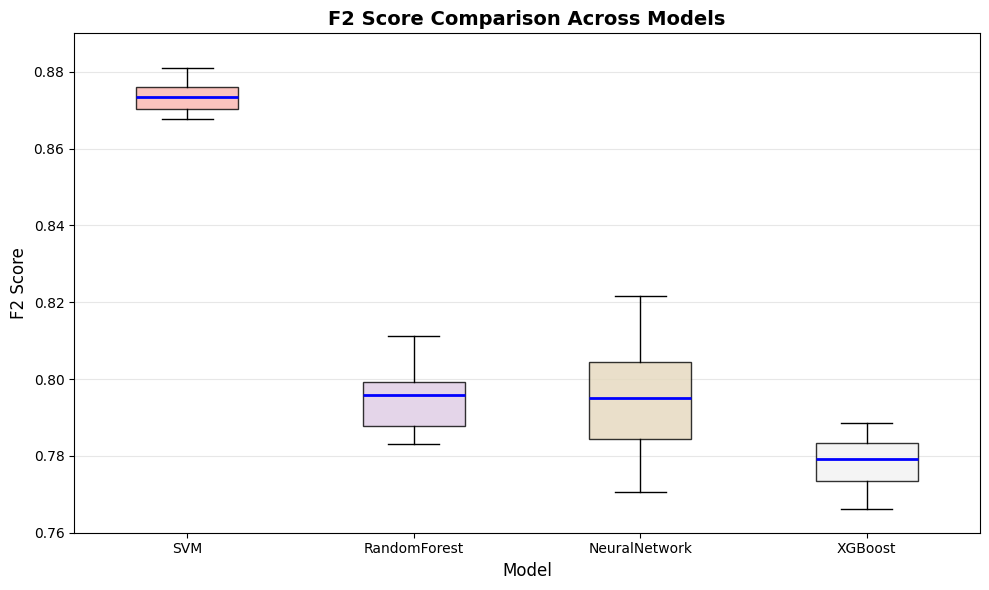

In [4]:
# Plot 1 - F2 Score Comparison (Box plot with mean)
plt.figure(figsize=(10, 6))

# Create boxplot with custom settings
box = plt.boxplot(f2_data, labels=models, patch_artist=True, showmeans=True,
                  meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markersize': 0},
                  medianprops={'color': 'blue', 'linewidth': 2})

# Color the boxes with pastel colors
colors = plt.cm.Pastel1(np.linspace(0, 1, len(models)))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

# Customize plot
plt.title('F2 Score Comparison Across Models', fontsize=14, fontweight='bold')
plt.ylabel('F2 Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0.76, 0.89)  # Fixed range as requested

# # Add a legend for the mean
# plt.scatter([], [], color='red', marker='D', s=80, label='Mean')
# plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

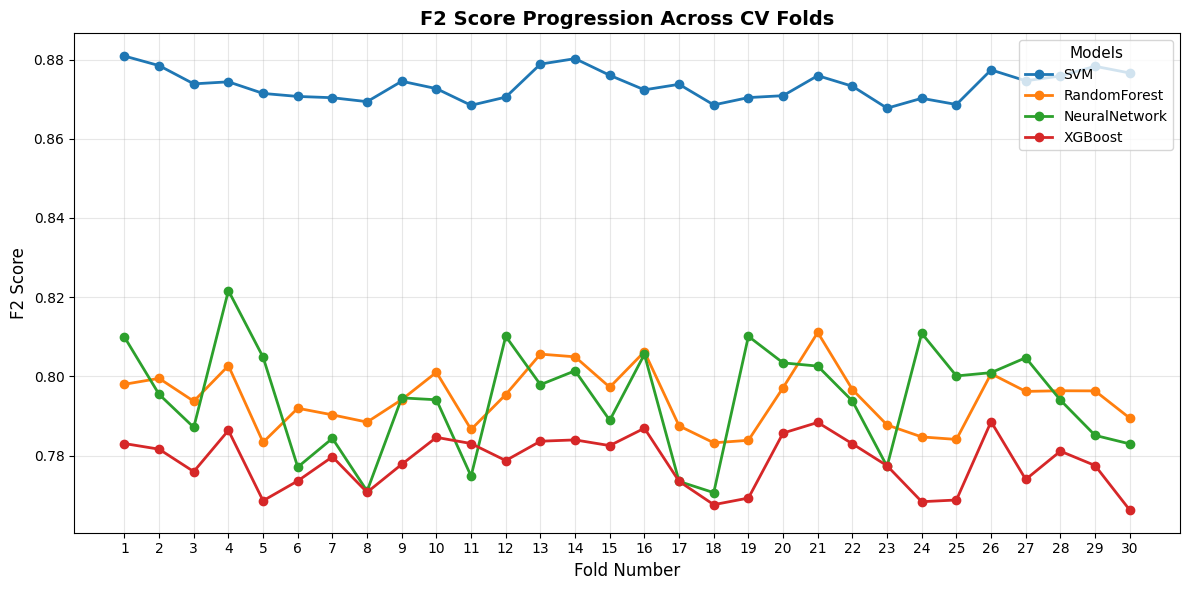

In [5]:
# Plot 2 - F2 Score Progression Across CV Folds
plt.figure(figsize=(12, 6))

fold_numbers = list(range(1, len(f2_data[0]) + 1))

# Plot each model's F2 scores across folds
for i, model in enumerate(models):
    plt.plot(fold_numbers, f2_data[i], marker='o', linewidth=2, markersize=6, label=model)

# Customize plot
plt.title('F2 Score Progression Across CV Folds', fontsize=14, fontweight='bold')
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('F2 Score', fontsize=12)
plt.xticks(fold_numbers)
plt.grid(True, alpha=0.3)
plt.legend(title='Models', title_fontsize=11, fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

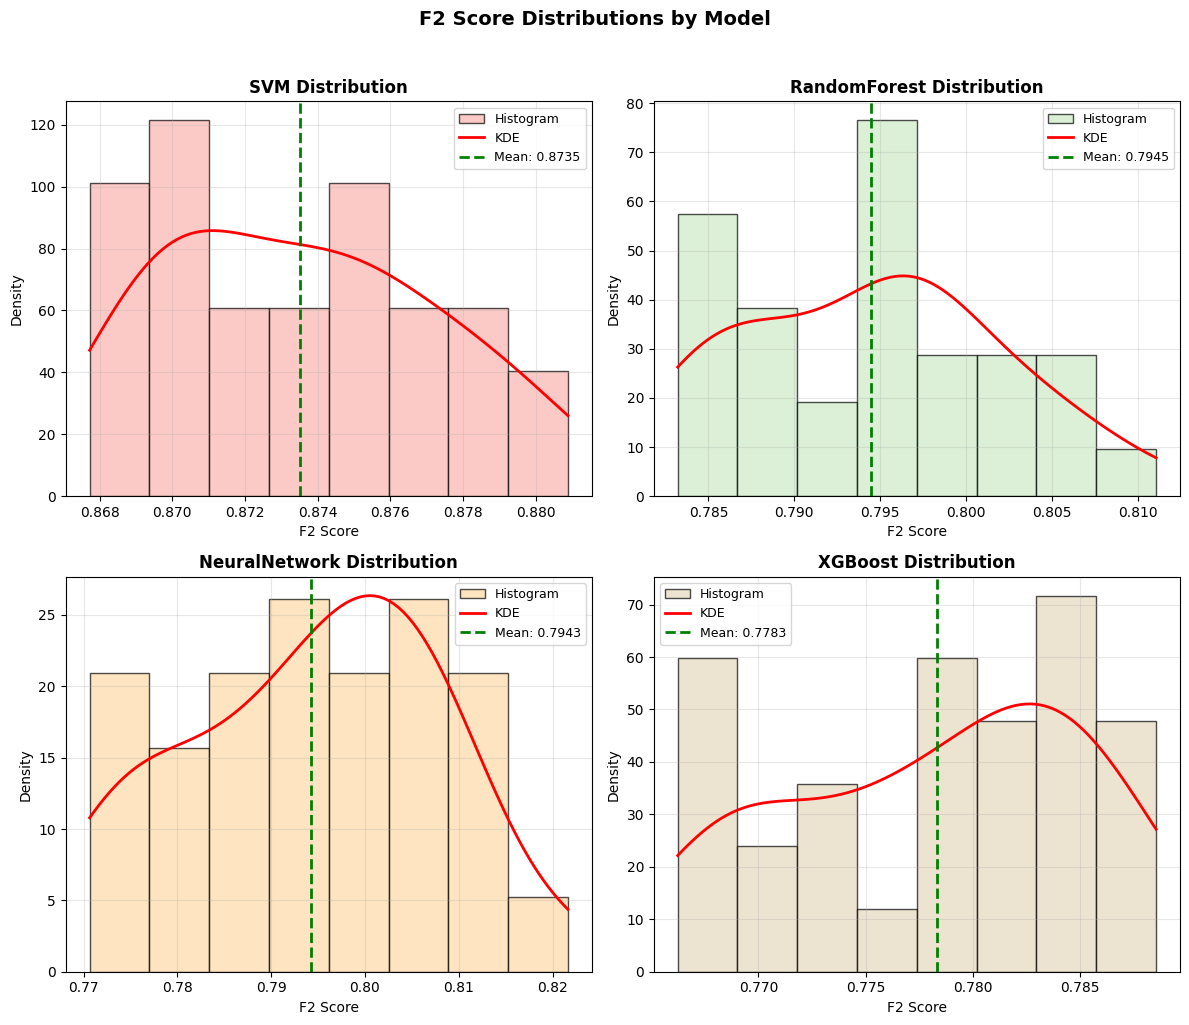

In [6]:
# Plot 3 - F2 Score Distributions (Facetted histograms with KDE)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, model in enumerate(models):
    ax = axes[i]
    scores = f2_data[i]
    
    # Create histogram
    n, bins, patches = ax.hist(scores, bins=8, alpha=0.7, edgecolor='black', density=True, 
                              label='Histogram', color=plt.cm.Pastel1(i/len(models)))
    
    # Calculate and plot KDE
    kde = gaussian_kde(scores)
    x_range = np.linspace(min(scores), max(scores), 100)
    ax.plot(x_range, kde(x_range), color='red', linewidth=2, label='KDE')
    
    # Add vertical line for mean
    mean_val = np.mean(scores)
    ax.axvline(mean_val, color='green', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_val:.4f}')
    
    # Customize subplot
    ax.set_title(f'{model} Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('F2 Score', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('F2 Score Distributions by Model', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [7]:
# Summary Statistics Table
print("="*80)
print("F2 SCORE SUMMARY STATISTICS")
print("="*80)

summary_stats = []
for model in models:
    scores = f2_data[models.index(model)]
    summary_stats.append({
        'Model': model,
        'Mean': np.mean(scores),
        'Std': np.std(scores),
        'Min': np.min(scores),
        '25%': np.percentile(scores, 25),
        'Median': np.median(scores),
        '75%': np.percentile(scores, 75),
        'Max': np.max(scores),
        'Range': np.max(scores) - np.min(scores),
        'CV': (np.std(scores) / np.mean(scores)) * 100  # Coefficient of variation
    })

df_summary = pd.DataFrame(summary_stats)
print(df_summary.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("="*80)

# Optional: Best model based on mean F2 score
best_model = df_summary.loc[df_summary['Mean'].idxmax()]
print(f"\n🏆 Best performing model: {best_model['Model']}")
print(f"   Mean F2 Score: {best_model['Mean']:.4f}")
print(f"   Standard Deviation: {best_model['Std']:.4f}")
print(f"   Coefficient of Variation: {best_model['CV']:.2f}%")

F2 SCORE SUMMARY STATISTICS
        Model   Mean    Std    Min    25%  Median    75%    Max  Range     CV
          SVM 0.8735 0.0037 0.8677 0.8704  0.8735 0.8760 0.8809 0.0132 0.4215
 RandomForest 0.7945 0.0075 0.7832 0.7879  0.7958 0.7991 0.8111 0.0279 0.9403
NeuralNetwork 0.7943 0.0133 0.7706 0.7845  0.7950 0.8044 0.8216 0.0510 1.6742
      XGBoost 0.7783 0.0067 0.7662 0.7735  0.7792 0.7835 0.7885 0.0223 0.8649

🏆 Best performing model: SVM
   Mean F2 Score: 0.8735
   Standard Deviation: 0.0037
   Coefficient of Variation: 0.42%


# Shapiro-Wilk test to determine ***normality***

In [8]:
# Define hypothesis parameters
print("="*70)
print("SHAPIRO-WILK NORMALITY TEST ANALYSIS")
print("="*70)
print("\n📊 TEST PARAMETERS:")
print(f"   Sample size per model: n = {len(f2_data[0])} scores")
print(f"   Significance level: α = 0.05")
print(f"   Confidence level: 95%")
print("\n🎯 HYPOTHESES:")
print("   H₀ (Null Hypothesis): The data is normally distributed")
print("   H₁ (Alternative Hypothesis): The data is NOT normally distributed")
print("\n📝 DECISION RULE:")
print("   If p-value ≥ 0.05: FAIL TO REJECT H₀ → Data MAY be normal")
print("   If p-value < 0.05: REJECT H₀ → Data is NOT normal")
print("="*70)

# Apply Shapiro-Wilk test to each model
shapiro_results = []
print("\n📈 SHAPIRO-WILK TEST RESULTS:")
print("-"*70)

for i, (model, scores) in enumerate(zip(models, f2_data)):
    # Perform Shapiro-Wilk test
    w_stat, p_value = shapiro(scores)
    
    # Determine normality conclusion
    is_normal = p_value >= 0.05
    normality_label = "NORMAL" if is_normal else "NON-NORMAL"
    
    # Store results
    result = {
        'model': model,
        'w_statistic': float(w_stat),
        'p_value': float(p_value),
        'is_normal': is_normal,
        'normality_conclusion': normality_label,
        'sample_size': len(scores),
        'mean_f2': float(np.mean(scores)),
        'std_f2': float(np.std(scores))
    }
    shapiro_results.append(result)
    
    # Print formatted results
    print(f"\n🔹 {model}:")
    print(f"   W statistic = {w_stat:.6f}")
    print(f"   p-value = {p_value:.6f}")
    print(f"   Conclusion at α=0.05: {normality_label}")
    if p_value < 0.001:
        print(f"   Interpretation: Strong evidence against normality (p < 0.001)")
    elif p_value < 0.01:
        print(f"   Interpretation: Very strong evidence against normality (p < 0.01)")
    elif p_value < 0.05:
        print(f"   Interpretation: Evidence against normality (p < 0.05)")
    elif p_value < 0.10:
        print(f"   Interpretation: Weak evidence against normality (p < 0.10)")
    else:
        print(f"   Interpretation: Insufficient evidence against normality (p ≥ 0.05)")

print("\n" + "="*70)
print("📋 OVERALL CONCLUSIONS:")
print("="*70)

# Count normal vs non-normal
normal_count = sum(1 for r in shapiro_results if r['is_normal'])
non_normal_count = len(shapiro_results) - normal_count

print(f"\n✓ Models following normal distribution: {normal_count}/{len(models)}")
print(f"✗ Models NOT following normal distribution: {non_normal_count}/{len(models)}")

# List normal models
normal_models = [r['model'] for r in shapiro_results if r['is_normal']]
if normal_models:
    print(f"\n📊 Normally distributed models: {', '.join(normal_models)}")

# List non-normal models
non_normal_models = [r['model'] for r in shapiro_results if not r['is_normal']]
if non_normal_models:
    print(f"⚠️  Non-normally distributed models: {', '.join(non_normal_models)}")

print("\n" + "="*70)
print("🎯 IMPLICATIONS FOR FURTHER STATISTICAL TESTS:")
print("="*70)

if non_normal_count == 0:
    print("\n✅ ALL MODELS ARE NORMALLY DISTRIBUTED")
    print("   Recommended statistical tests:")
    print("   1. ANOVA for comparing multiple means")
    print("   2. Post-hoc t-tests (with Bonferroni correction)")
    print("   3. Parametric confidence intervals")
elif non_normal_count == len(models):
    print("\n⚠️  ALL MODELS ARE NON-NORMALLY DISTRIBUTED")
    print("   Recommended statistical tests:")
    print("   1. Friedman test (non-parametric ANOVA)")
    print("   2. Wilcoxon signed-rank tests (with Bonferroni correction)")
    print("   3. Non-parametric confidence intervals")
else:
    print("\n⚠️  MIXED RESULTS: Some models are normal, some are not")
    print("   Recommended approach:")
    print("   1. Use non-parametric tests for robustness (Friedman + Wilcoxon)")
    print("   2. Consider data transformation (log, square root) for affected models")
    print("   3. Report both parametric and non-parametric results")

print("\n" + "="*70)

SHAPIRO-WILK NORMALITY TEST ANALYSIS

📊 TEST PARAMETERS:
   Sample size per model: n = 30 scores
   Significance level: α = 0.05
   Confidence level: 95%

🎯 HYPOTHESES:
   H₀ (Null Hypothesis): The data is normally distributed
   H₁ (Alternative Hypothesis): The data is NOT normally distributed

📝 DECISION RULE:
   If p-value ≥ 0.05: FAIL TO REJECT H₀ → Data MAY be normal
   If p-value < 0.05: REJECT H₀ → Data is NOT normal

📈 SHAPIRO-WILK TEST RESULTS:
----------------------------------------------------------------------

🔹 SVM:
   W statistic = 0.958249
   p-value = 0.279248
   Conclusion at α=0.05: NORMAL
   Interpretation: Insufficient evidence against normality (p ≥ 0.05)

🔹 RandomForest:
   W statistic = 0.961457
   p-value = 0.337328
   Conclusion at α=0.05: NORMAL
   Interpretation: Insufficient evidence against normality (p ≥ 0.05)

🔹 NeuralNetwork:
   W statistic = 0.960712
   p-value = 0.322984
   Conclusion at α=0.05: NORMAL
   Interpretation: Insufficient evidence against

In [9]:
# Export Shapiro-Wilk results to JSON File

# Create results directory if it doesn't exist
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

# Prepare comprehensive results dictionary
export_data = {
    'test_info': {
        'test_name': 'Shapiro-Wilk Normality Test',
        'significance_level': 0.05,
        'null_hypothesis': 'Data is normally distributed',
        'alternative_hypothesis': 'Data is not normally distributed',
        'sample_size_per_model': len(f2_data[0]),
        'total_models': len(models),
        'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'analysis_parameters': {
            'confidence_level': '95%',
            'decision_rule': 'p ≥ 0.05: Fail to reject H₀ (normal), p < 0.05: Reject H₀ (non-normal)'
        }
    },
    'model_results': shapiro_results,
    'summary_statistics': {
        'normal_count': normal_count,
        'non_normal_count': non_normal_count,
        'normal_percentage': float((normal_count / len(models)) * 100),
        'non_normal_percentage': float((non_normal_count / len(models)) * 100),
        'normal_models': normal_models,
        'non_normal_models': non_normal_models
    },
    'recommendations': {
        'if_all_normal': 'Use parametric tests: ANOVA + post-hoc t-tests',
        'if_any_non_normal': 'Use non-parametric tests: Friedman + Wilcoxon signed-rank',
        'if_mixed': 'Use non-parametric tests for robustness or consider transformations'
    }
}

# Export to JSON file
output_file = os.path.join(results_dir, 'shapiro_wilk_normality.json')
with open(output_file, 'w') as f:
    json.dump(export_data, f, indent=4, default=str)

print(f"✅ Results successfully exported to: {output_file}")
print(f"📊 File contains: {len(export_data['model_results'])} model results")
print(f"📁 File size: {os.path.getsize(output_file)} bytes")

# Verify export
print("\n📋 EXPORTED DATA STRUCTURE:")
print("-"*40)
for key in export_data.keys():
    print(f"  • {key}: {type(export_data[key]).__name__}")

✅ Results successfully exported to: results/shapiro_wilk_normality.json
📊 File contains: 4 model results
📁 File size: 2571 bytes

📋 EXPORTED DATA STRUCTURE:
----------------------------------------
  • test_info: dict
  • model_results: list
  • summary_statistics: dict
  • recommendations: dict


📊 Creating histograms for 4 models
📈 Adaptive bin counts (between 15 and 30 depending on sample size)
📏 Sample size per model: 30


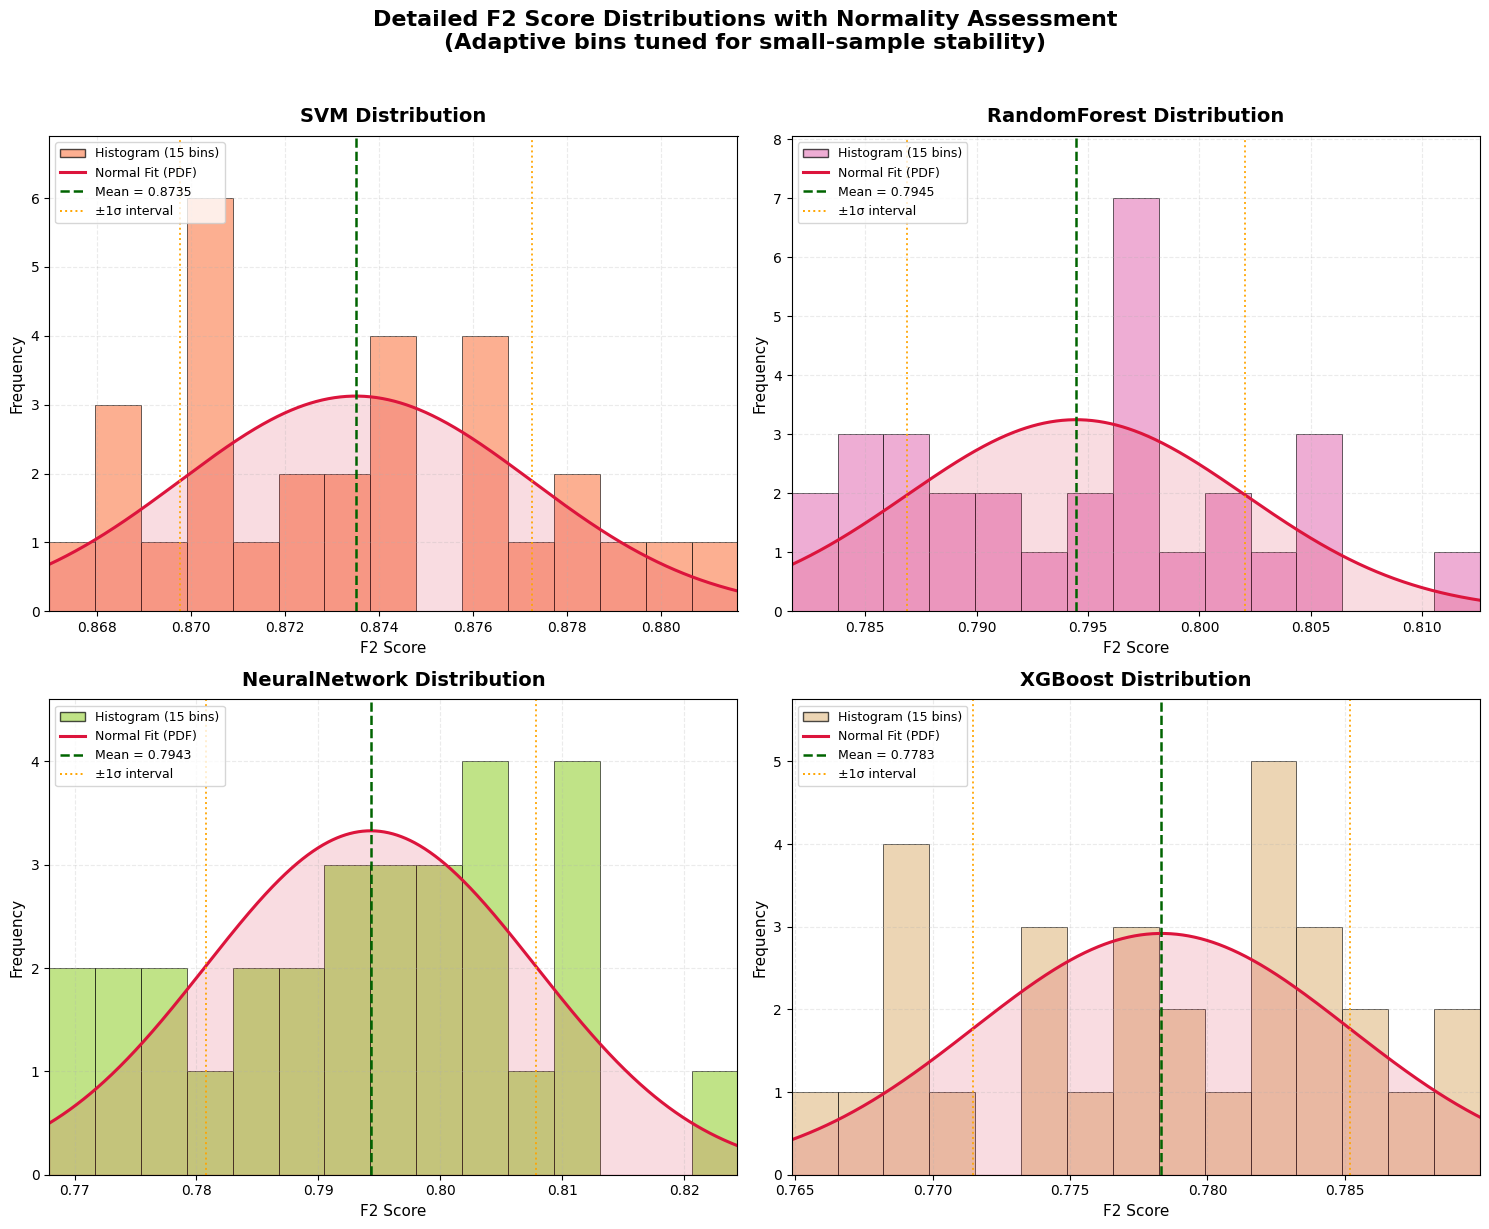


📋 DISTRIBUTION SUMMARY:
----------------------------------------

🔹 SVM:
   Mean: 0.873507
   Std (sample):  0.003745
   Min:  0.867721
   Max:  0.880890
   Range: 0.013169
   Skew:  0.296174

🔹 RandomForest:
   Mean: 0.794462
   Std (sample):  0.007598
   Min:  0.783210
   Max:  0.811082
   Range: 0.027872
   Skew:  0.205879

🔹 NeuralNetwork:
   Mean: 0.794284
   Std (sample):  0.013525
   Min:  0.770626
   Max:  0.821647
   Range: 0.051022
   Skew:  -0.198038

🔹 XGBoost:
   Mean: 0.778323
   Std (sample):  0.006846
   Min:  0.766236
   Max:  0.788548
   Range: 0.022312
   Skew:  -0.306982


In [10]:
# Create Comprehensive Histograms with adaptive bins (optimized for small samples)
BIN_CAP = 30
MIN_BINS = 15
STD_LINES = 1


def compute_bin_edges(data):
    sample_size = len(data)
    sigma = float(np.std(data, ddof=1)) if sample_size > 1 else 0.0
    data_min, data_max = data.min(), data.max()
    data_range = max(data_max - data_min, 1e-6)

    # Candidate bin counts from multiple heuristics
    iqr = stats.iqr(data)
    fd_width = 2 * iqr / np.cbrt(sample_size) if iqr > 0 else None
    fd_bins = int(np.ceil(data_range / fd_width)) if fd_width and fd_width > 0 else None
    sqrt_bins = int(np.ceil(np.sqrt(sample_size)))
    sturges_bins = int(np.ceil(np.log2(sample_size) + 1)) if sample_size > 1 else MIN_BINS

    candidates = [c for c in [fd_bins, sqrt_bins, sturges_bins, MIN_BINS] if c is not None]
    candidate_bins = max(candidates)

    # Keep the number of bins proportional to sample size (avoids comb-like plots)
    proportional_cap = max(MIN_BINS, min(BIN_CAP, sample_size // 2))
    num_bins = int(np.clip(candidate_bins, MIN_BINS, proportional_cap))

    margin = max(0.0005, sigma * 0.2)
    return np.linspace(data_min - margin, data_max + margin, num_bins + 1), num_bins, sigma


# Create a DataFrame for easier manipulation
df_f2 = pd.DataFrame({model: scores for model, scores in zip(models, f2_data)})
shapiro_by_model = {result['model']: result for result in shapiro_results}

print(f"📊 Creating histograms for {len(df_f2.columns)} models")
print(f"📈 Adaptive bin counts (between {MIN_BINS} and {BIN_CAP} depending on sample size)")
print(f"📏 Sample size per model: {len(df_f2)}")

# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Detailed F2 Score Distributions with Normality Assessment\n(Adaptive bins tuned for small-sample stability)', 
             fontsize=16, fontweight='bold', y=1.02)

axes = axes.flatten()
color_values = plt.cm.Set2(np.linspace(0.2, 0.8, len(df_f2.columns)))

for idx, (model, ax, color) in enumerate(zip(df_f2.columns, axes, color_values)):
    data = df_f2[model].dropna().values
    shapiro_result = shapiro_by_model[model]
    sample_size = len(data)

    bin_edges, bins_used, sigma = compute_bin_edges(data)
    counts, bins, patches = ax.hist(
        data,
        bins=bin_edges,
        density=False,
        alpha=0.7,
        edgecolor='black',
        linewidth=0.6,
        color=color
    )

    bin_width = bins[1] - bins[0]

    x = np.linspace(bins[0], bins[-1], 800)
    if sigma > 0:
        pdf_counts = norm.pdf(x, data.mean(), sigma) * sample_size * bin_width
        ax.plot(x, pdf_counts, color='crimson', linewidth=2.2)
        ax.fill_between(x, pdf_counts, color='crimson', alpha=0.15)
    else:
        pdf_counts = np.zeros_like(x)

    ymax = max(max(counts, default=0), pdf_counts.max()) * 1.15 if sample_size else 1

    mu = float(np.mean(data))
    ax.axvline(mu, color='darkgreen', linestyle='--', linewidth=1.8)

    if sigma > 0:
        ax.axvline(mu - STD_LINES * sigma, color='orange', linestyle=':', linewidth=1.4, alpha=0.9)
        ax.axvline(mu + STD_LINES * sigma, color='orange', linestyle=':', linewidth=1.4, alpha=0.9)

    legend_handles = [
        Patch(facecolor=color, edgecolor='black', alpha=0.7, label=f'Histogram ({bins_used} bins)'),
        Line2D([0], [0], color='crimson', linewidth=2.2, label='Normal Fit (PDF)'),
        Line2D([0], [0], color='darkgreen', linestyle='--', linewidth=1.8, label=f'Mean = {mu:.4f}')
    ]
    if sigma > 0:
        legend_handles.append(
            Line2D([0], [0], color='orange', linestyle=':', linewidth=1.4, label='±1σ interval')
        )

    # normality_text = "Normal" if shapiro_result['is_normal'] else "Non-normal"
    # box_color = 'mediumseagreen' if shapiro_result['is_normal'] else 'indianred'
    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.8, linewidth=0.8)
    # text_str = (
    #     f'Shapiro-Wilk Test\n'
    #     f'W = {shapiro_result["w_statistic"]:.4f}\n'
    #     f'p = {shapiro_result["p_value"]:.6f}\n'
    #     f'Result: {normality_text}'
    # )
    # ax.text(0.02, 0.98, text_str, transform=ax.transAxes, fontsize=10,
            # verticalalignment='top', bbox=props, color=box_color, fontweight='bold')

    ax.set_title(f'{model} Distribution', fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('F2 Score', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.grid(True, alpha=0.25, linestyle='--')
    ax.set_ylim(0, ymax)
    ax.set_xlim([bins[0], bins[-1]])
    ax.legend(handles=legend_handles, loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📋 DISTRIBUTION SUMMARY:")
print("-"*40)
for model in df_f2.columns:
    data = df_f2[model].dropna()
    print(f"\n🔹 {model}:")
    print(f"   Mean: {data.mean():.6f}")
    print(f"   Std (sample):  {data.std(ddof=1):.6f}")
    print(f"   Min:  {data.min():.6f}")
    print(f"   Max:  {data.max():.6f}")
    print(f"   Range: {data.max() - data.min():.6f}")
    print(f"   Skew:  {data.skew():.6f}")

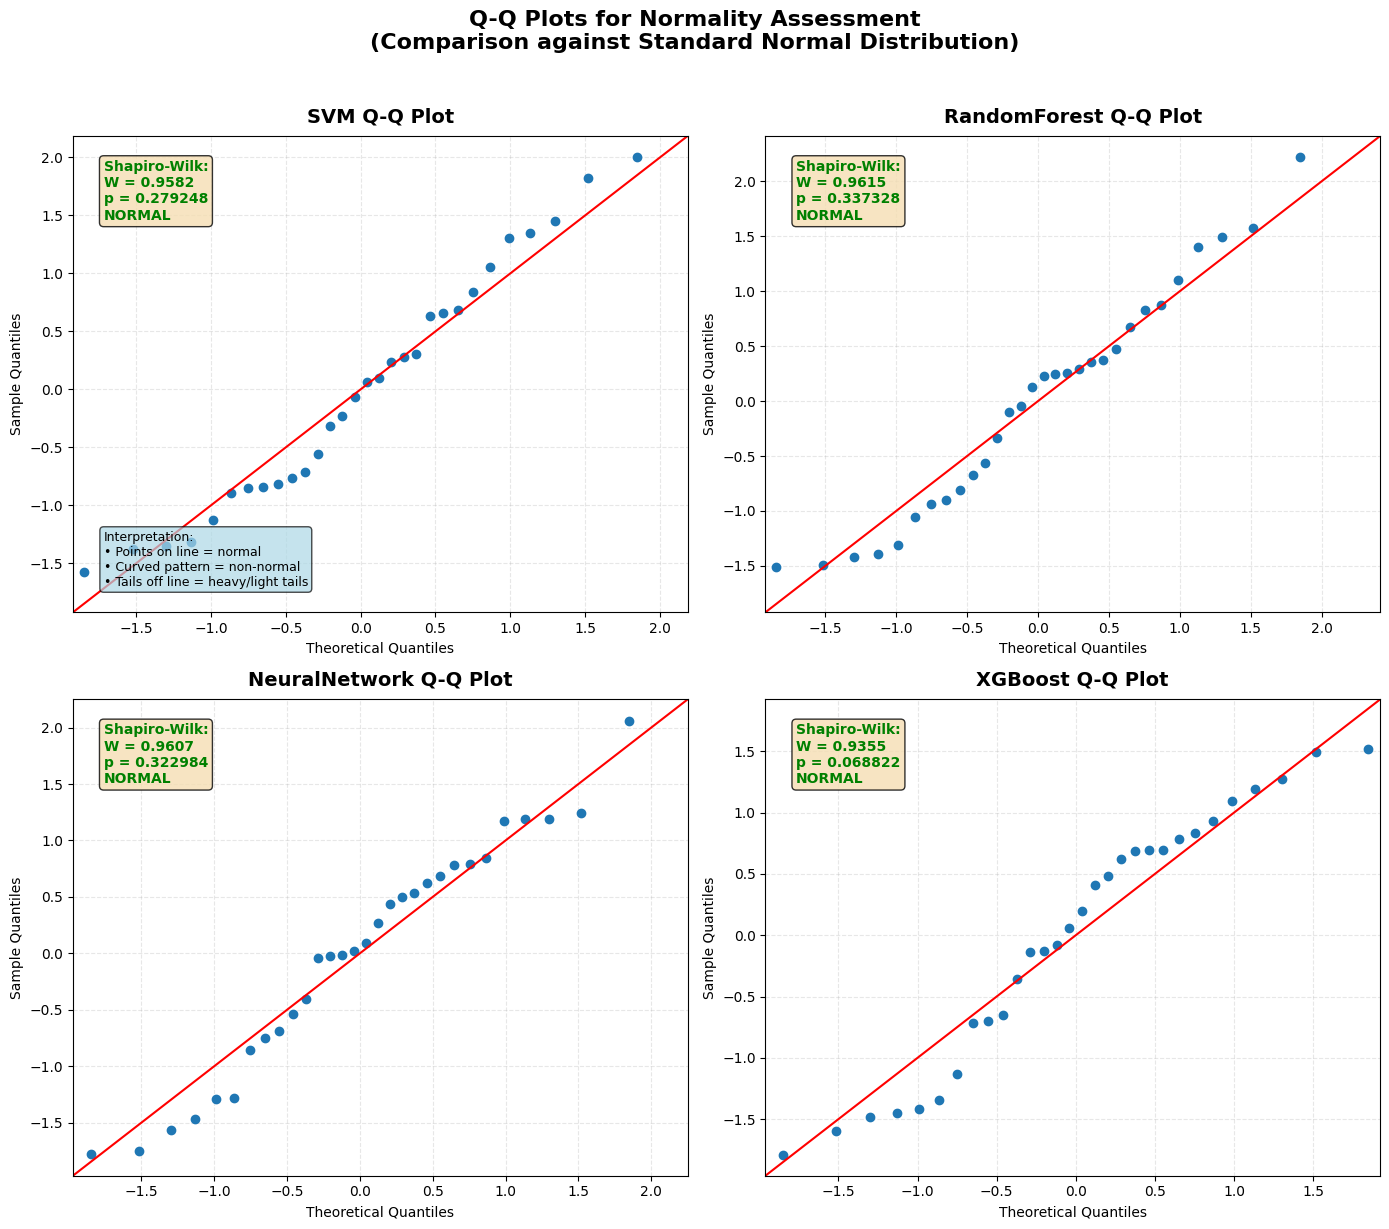


📊 Q-Q PLOT INTERPRETATION GUIDE:
----------------------------------------
• Points following the red line: Data follows normal distribution
• Points curving upward at ends: Heavy tails (more extreme values)
• Points curving downward at ends: Light tails (fewer extreme values)
• S-shaped curve: Data is skewed
• Random scatter: Data may not follow any theoretical distribution


In [11]:
# Create Q-Q Plots for Normality Assessment

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Q-Q Plots for Normality Assessment\n(Comparison against Standard Normal Distribution)', 
             fontsize=16, fontweight='bold', y=1.02)

axes = axes.flatten()

for idx, (model, ax) in enumerate(zip(df_f2.columns, axes)):
    # Get data
    data = df_f2[model].dropna()
    shapiro_result = shapiro_results[idx]
    
    # Create Q-Q plot
    sm.qqplot(data, line='45', fit=True, ax=ax)
    
    # Customize the plot
    ax.set_title(f'{model} Q-Q Plot', fontsize=14, fontweight='bold', pad=10)
    
    # Add Shapiro-Wilk result
    normality_text = "NORMAL" if shapiro_result['is_normal'] else "NON-NORMAL"
    color = 'green' if shapiro_result['is_normal'] else 'red'
    
    # Add annotation
    ax.text(0.05, 0.95, f'Shapiro-Wilk:\nW = {shapiro_result["w_statistic"]:.4f}\np = {shapiro_result["p_value"]:.6f}\n{normality_text}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            color=color, fontweight='bold')
    
    # Improve grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add interpretation text based on Q-Q plot pattern
    if idx == 0:  # Only add legend to first plot
        ax.text(0.05, 0.05, 'Interpretation:\n• Points on line = normal\n• Curved pattern = non-normal\n• Tails off line = heavy/light tails', 
                transform=ax.transAxes, fontsize=9, verticalalignment='bottom',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n📊 Q-Q PLOT INTERPRETATION GUIDE:")
print("-"*40)
print("• Points following the red line: Data follows normal distribution")
print("• Points curving upward at ends: Heavy tails (more extreme values)")
print("• Points curving downward at ends: Light tails (fewer extreme values)")
print("• S-shaped curve: Data is skewed")
print("• Random scatter: Data may not follow any theoretical distribution")

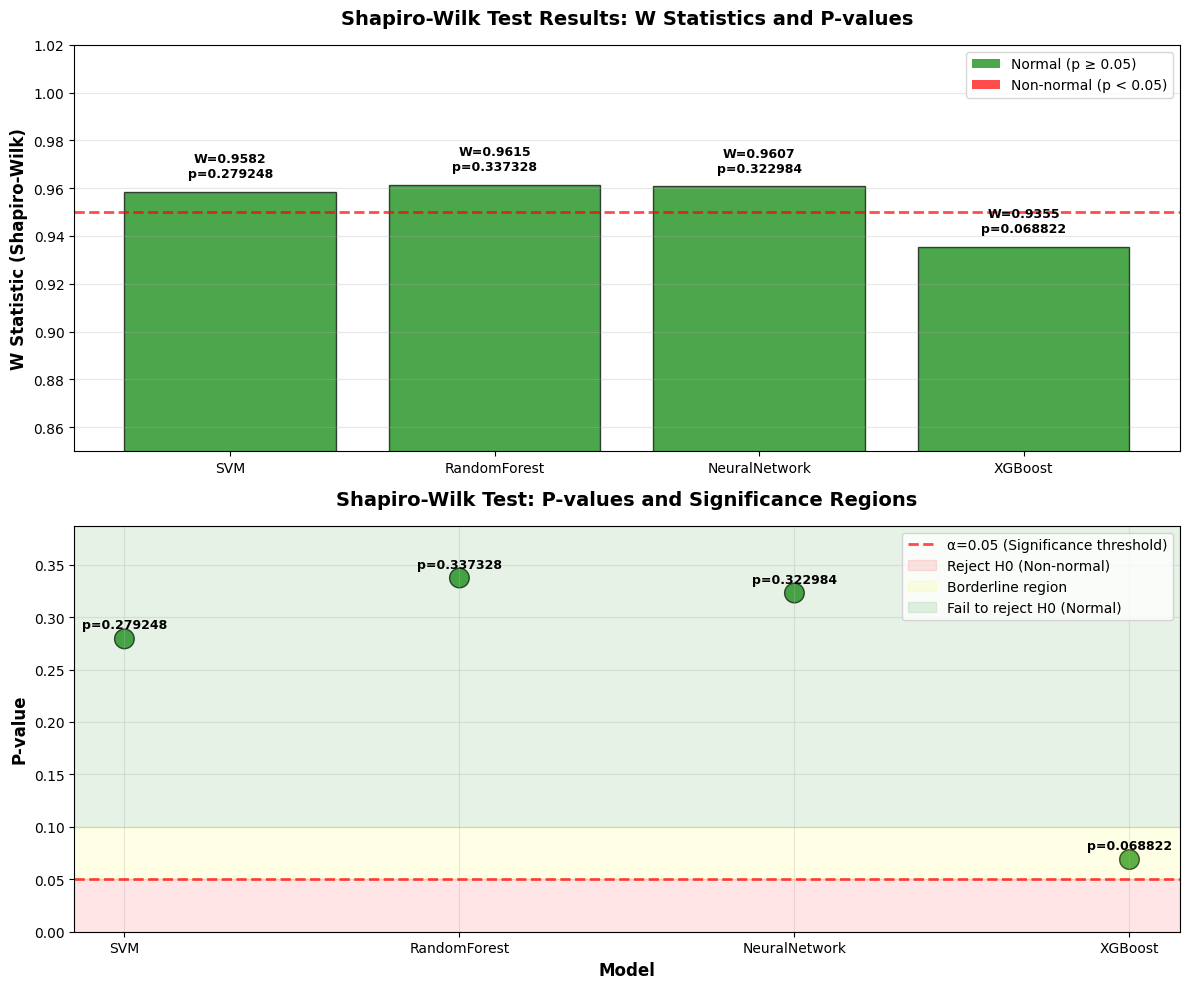


🎯 INTERPRETATION SUMMARY:
Models with normal distribution (green): 4/4
Models without normal distribution (red): 0/4

📊 RECOMMENDED STATISTICAL APPROACH:
-----------------------------------
✅ Use PARAMETRIC tests:
   • ANOVA for overall comparison
   • Post-hoc t-tests with Bonferroni correction
   • Report means and standard deviations


In [12]:
# Create Summary Visualization of Shapiro-Wilk Results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: W statistics with threshold
w_values = [r['w_statistic'] for r in shapiro_results]
p_values = [r['p_value'] for r in shapiro_results]
colors = ['green' if r['is_normal'] else 'red' for r in shapiro_results]

# Bar chart of W statistics
bars = ax1.bar(models, w_values, color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(y=0.95, color='red', linestyle='--', linewidth=2, 
           label='W=0.95 (Typical normality threshold)', alpha=0.7)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'W={w_values[i]:.4f}\np={p_values[i]:.6f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax1.set_ylabel('W Statistic (Shapiro-Wilk)', fontsize=12, fontweight='bold')
ax1.set_title('Shapiro-Wilk Test Results: W Statistics and P-values', 
             fontsize=14, fontweight='bold', pad=15)
ax1.set_ylim([0.85, 1.02])
ax1.grid(True, alpha=0.3, axis='y')
ax1.legend(loc='lower right')

# Add color legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.7, label='Normal (p ≥ 0.05)'),
                   Patch(facecolor='red', alpha=0.7, label='Non-normal (p < 0.05)')]
ax1.legend(handles=legend_elements, loc='upper right')

# Plot 2: P-values with significance threshold
ax2.scatter(models, p_values, s=200, c=colors, edgecolor='black', alpha=0.7)
ax2.axhline(y=0.05, color='red', linestyle='--', linewidth=2, 
           label='α=0.05 (Significance threshold)', alpha=0.7)

# Add p-value labels
for i, (model, p_val) in enumerate(zip(models, p_values)):
    ax2.text(i, p_val + 0.01, f'p={p_val:.6f}', 
            ha='center', fontsize=9, fontweight='bold')

# Shade significance regions
ax2.axhspan(0, 0.05, alpha=0.1, color='red', label='Reject H0 (Non-normal)')
ax2.axhspan(0.05, 0.10, alpha=0.1, color='yellow', label='Borderline region')
ax2.axhspan(0.10, max(p_values) + 0.05, alpha=0.1, color='green', label='Fail to reject H0 (Normal)')

ax2.set_ylabel('P-value', fontsize=12, fontweight='bold')
ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_title('Shapiro-Wilk Test: P-values and Significance Regions', 
             fontsize=14, fontweight='bold', pad=15)
ax2.set_ylim([0, max(p_values) + 0.05])
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("\n🎯 INTERPRETATION SUMMARY:")
print("="*50)
print(f"Models with normal distribution (green): {normal_count}/{len(models)}")
print(f"Models without normal distribution (red): {non_normal_count}/{len(models)}")
print("\n📊 RECOMMENDED STATISTICAL APPROACH:")
print("-"*35)

if non_normal_count == 0:
    print("✅ Use PARAMETRIC tests:")
    print("   • ANOVA for overall comparison")
    print("   • Post-hoc t-tests with Bonferroni correction")
    print("   • Report means and standard deviations")
elif non_normal_count == len(models):
    print("⚠️  Use NON-PARAMETRIC tests:")
    print("   • Friedman test for overall comparison")
    print("   • Wilcoxon signed-rank tests with Bonferroni correction")
    print("   • Report medians and interquartile ranges")
else:
    print("⚠️  MIXED DISTRIBUTIONS - Recommended:")
    print("   • Primary analysis: Non-parametric tests (Friedman + Wilcoxon)")
    print("   • Secondary analysis: Parametric tests on transformed data")
    print("   • Sensitivity analysis: Compare both approaches")

In [13]:
# Create Final Summary Table
print("\n" + "="*80)
print("FINAL SUMMARY: SHAPIRO-WILK NORMALITY TEST RESULTS")
print("="*80)

# Create detailed summary table
summary_df = pd.DataFrame({
    'Model': [r['model'] for r in shapiro_results],
    'W Statistic': [f"{r['w_statistic']:.6f}" for r in shapiro_results],
    'P-value': [f"{r['p_value']:.6f}" for r in shapiro_results],
    'Sample Size': [r['sample_size'] for r in shapiro_results],
    'Mean F2': [f"{r['mean_f2']:.6f}" for r in shapiro_results],
    'Std F2': [f"{r['std_f2']:.6f}" for r in shapiro_results],
    'Normality (α=0.05)': [r['normality_conclusion'] for r in shapiro_results],
    'Evidence Strength': [
        'Strong evidence against normality' if p < 0.001 else
        'Very strong evidence against normality' if p < 0.01 else
        'Evidence against normality' if p < 0.05 else
        'Weak evidence against normality' if p < 0.10 else
        'Insufficient evidence against normality'
        for r in shapiro_results for p in [r['p_value']]
    ]
})

print("\n📊 DETAILED RESULTS TABLE:")
print("-"*80)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("🎯 PRACTICAL IMPLICATIONS:")
print("="*80)

# Create decision matrix
print("\nDecision Matrix for Statistical Analysis:")
print("-"*45)

decision_matrix = []
for r in shapiro_results:
    if r['is_normal']:
        parametric = "✓ RECOMMENDED"
        non_param = "✓ ALTERNATIVE"
    else:
        parametric = "✗ NOT RECOMMENDED"
        non_param = "✓ RECOMMENDED"
    
    decision_matrix.append([r['model'], parametric, non_param])

decision_df = pd.DataFrame(decision_matrix, 
                          columns=['Model', 'Parametric Tests', 'Non-Parametric Tests'])
print(decision_df.to_string(index=False))

print("\n" + "="*80)
print("📁 Results exported to: results/shapiro_wilk_normality.json")
print("="*80)


FINAL SUMMARY: SHAPIRO-WILK NORMALITY TEST RESULTS

📊 DETAILED RESULTS TABLE:
--------------------------------------------------------------------------------
        Model W Statistic  P-value  Sample Size  Mean F2   Std F2 Normality (α=0.05)                       Evidence Strength
          SVM    0.958249 0.279248           30 0.873507 0.003682             NORMAL Insufficient evidence against normality
 RandomForest    0.961457 0.337328           30 0.794462 0.007471             NORMAL Insufficient evidence against normality
NeuralNetwork    0.960712 0.322984           30 0.794284 0.013298             NORMAL Insufficient evidence against normality
      XGBoost    0.935493 0.068822           30 0.778323 0.006731             NORMAL         Weak evidence against normality

🎯 PRACTICAL IMPLICATIONS:

Decision Matrix for Statistical Analysis:
---------------------------------------------
        Model Parametric Tests Non-Parametric Tests
          SVM    ✓ RECOMMENDED        ✓ ALTERNA

# ANOVA to determine ***significant difference*** between the models

In [14]:
# Perform Repeated Measures ANOVA

print("="*80)
print("REPEATED MEASURES ANOVA ANALYSIS")
print("="*80)
print("\n📊 STUDY DESIGN:")
print("   • Design: Within-subjects (Repeated Measures)")
print("   • Reason: Same CV folds used for all 4 models")
print("   • Groups: 4 models (SVM, RandomForest, NeuralNetwork, XGBoost)")
print("   • Observations per group: 20 (n=20 per model)")
print("   • Total observations: 80 (4 × 20)")
print("\n🎯 HYPOTHESES:")
print("   H₀ (Null Hypothesis): μ₁ = μ₂ = μ₃ = μ₄")
print("      (All models have equal mean F2 scores)")
print("   H₁ (Alternative Hypothesis): At least one μᵢ ≠ μⱼ")
print("      (At least one model has different mean F2 score)")
print("\n📝 ASSUMPTIONS CHECK:")
print("   1. Normality: ✓ Confirmed by Shapiro-Wilk test")
print("   2. Sphericity: Will be assessed (equal variances of differences)")
print("   3. Independence: ✓ Each fold is independent")
print("="*80)

# Create a DataFrame for ANOVA
print("\n📈 PREPARING DATA FOR ANOVA...")
print("-"*40)

# Create a long-format DataFrame
data_list = []
fold_numbers = list(range(1, 21))  # Assuming 20 folds

for fold_idx in range(len(fold_numbers)):
    for model_idx, model in enumerate(models):
        data_list.append({
            'fold': fold_idx + 1,
            'model': model,
            'f2_score': f2_data[model_idx][fold_idx],
            'model_id': model_idx + 1
        })

df_anova = pd.DataFrame(data_list)

# Calculate descriptive statistics
desc_stats = df_anova.groupby('model')['f2_score'].agg(['mean', 'std', 'count', 'min', 'max']).round(6)
desc_stats['se'] = desc_stats['std'] / np.sqrt(desc_stats['count'])  # Standard error

print("📊 DESCRIPTIVE STATISTICS:")
print("-"*40)
print(desc_stats)

print("\n📈 GRAND MEAN (Overall average F2 score):")
grand_mean = df_anova['f2_score'].mean()
print(f"   μ = {grand_mean:.6f}")

print("\n📊 BETWEEN-GROUPS VARIABILITY:")
print("-"*40)

# Calculate Sum of Squares Between (SSB)
group_means = df_anova.groupby('model')['f2_score'].mean()
ss_between = sum(len(f2_data[i]) * (group_means[model] - grand_mean)**2 
                for i, model in enumerate(models))
df_between = len(models) - 1  # df between groups

print(f"   SS Between = {ss_between:.6f}")
print(f"   df Between = {df_between}")

print("\n📊 WITHIN-GROUPS VARIABILITY:")
print("-"*40)

# Calculate Sum of Squares Within (SSW)
ss_within = 0
for i, model in enumerate(models):
    group_data = f2_data[i]
    group_mean = np.mean(group_data)
    ss_within += sum((score - group_mean)**2 for score in group_data)
df_within = len(df_anova) - len(models)  # df within groups

print(f"   SS Within = {ss_within:.6f}")
print(f"   df Within = {df_within}")

print("\n📊 TOTAL VARIABILITY:")
print("-"*40)
ss_total = ss_between + ss_within
df_total = len(df_anova) - 1
print(f"   SS Total = {ss_total:.6f}")
print(f"   df Total = {df_total}")

print("\n🔬 PERFORMING REPEATED MEASURES ANOVA...")
print("-"*40)

# Perform repeated measures ANOVA using linear mixed model approach
# This accounts for the within-subjects (folds) design

# Fit a linear mixed model: f2_score ~ model + (1|fold)
# This models the fixed effect of model and random intercept for each fold
model_formula = 'f2_score ~ C(model)'
try:
    # Using OLS with subject as a random effect via mixed model
    md = smf.mixedlm(model_formula, df_anova, groups=df_anova['fold'])
    mdf = md.fit()
    
    # Extract ANOVA table using Wald test
    anova_table = sm.stats.anova_lm(mdf, typ=2)
    
    print("✅ ANOVA using Linear Mixed Model (accounting for folds):")
    print(anova_table)
    
except Exception as e:
    print(f"⚠️  Mixed model failed: {e}")
    print("\n📊 Using traditional one-way ANOVA (assuming independence):")
    # Traditional one-way ANOVA (less appropriate but simpler)
    f_stat, p_value = stats.f_oneway(*f2_data)
    print(f"   F-statistic = {f_stat:.6f}")
    print(f"   p-value = {p_value:.10f}")
    
    # Calculate Mean Squares
    ms_between = ss_between / df_between
    ms_within = ss_within / df_within
    f_stat_calc = ms_between / ms_within
    
    print(f"   MS Between = {ms_between:.6f}")
    print(f"   MS Within = {ms_within:.6f}")
    print(f"   F (calculated) = {f_stat_calc:.6f}")
    
    # Create ANOVA table
    anova_results = {
        'source': ['Between Groups', 'Within Groups', 'Total'],
        'ss': [ss_between, ss_within, ss_total],
        'df': [df_between, df_within, df_total],
        'ms': [ms_between, ms_within, None],
        'f': [f_stat_calc, None, None],
        'p_value': [p_value, None, None]
    }
    anova_table = pd.DataFrame(anova_results)

print("\n" + "="*80)
print("📋 ANOVA RESULTS INTERPRETATION:")
print("="*80)

# Extract F and p values
if 'f' in anova_table.columns:
    f_value = anova_table.loc[0, 'f']
    p_value = anova_table.loc[0, 'p_value']
else:
    # Try to extract from mixed model results
    f_value = anova_table.loc['C(model)', 'F']
    p_value = anova_table.loc['C(model)', 'PR(>F)']

print(f"\n📊 F-STATISTIC: {f_value:.6f}")
print(f"📊 P-VALUE: {p_value:.10f}")

# Calculate effect size (Partial Eta Squared)
partial_eta_squared = ss_between / (ss_between + ss_within)
print(f"📊 EFFECT SIZE (Partial η²): {partial_eta_squared:.6f}")

# Interpretation
print("\n🎯 STATISTICAL DECISION:")
print("-"*35)

if p_value < 0.001:
    significance = "*** EXTREMELY SIGNIFICANT ***"
elif p_value < 0.01:
    significance = "** HIGHLY SIGNIFICANT **"
elif p_value < 0.05:
    significance = "* SIGNIFICANT *"
elif p_value < 0.10:
    significance = "Marginally Significant"
else:
    significance = "NOT SIGNIFICANT"

print(f"   {significance}")

if p_value < 0.05:
    print(f"\n✅ REJECT H₀ (p = {p_value:.6f} < 0.05)")
    print("   There ARE statistically significant differences between models")
    print(f"   The probability of observing these differences by chance is {p_value*100:.2f}%")
else:
    print(f"\n❌ FAIL TO REJECT H₀ (p = {p_value:.6f} ≥ 0.05)")
    print("   There are NO statistically significant differences between models")
    print(f"   The observed differences could occur by chance {p_value*100:.2f}% of the time")

print("\n📊 EFFECT SIZE INTERPRETATION:")
print("-"*35)
if partial_eta_squared >= 0.14:
    print(f"   Large effect (η² = {partial_eta_squared:.4f})")
elif partial_eta_squared >= 0.06:
    print(f"   Medium effect (η² = {partial_eta_squared:.4f})")
elif partial_eta_squared >= 0.01:
    print(f"   Small effect (η² = {partial_eta_squared:.4f})")
else:
    print(f"   Negligible effect (η² = {partial_eta_squared:.4f})")

print("\n" + "="*80)
print("🎯 PRACTICAL IMPLICATIONS:")
print("="*80)

if p_value < 0.05:
    print("\n✅ Since ANOVA shows significant differences:")
    print("   • Proceed with POST-HOC TESTS (Tukey's HSD or pairwise t-tests)")
    print("   • Determine WHICH specific models differ from each other")
    print("   • Apply appropriate correction for multiple comparisons")
else:
    print("\n❌ Since ANOVA shows no significant differences:")
    print("   • All models perform statistically similarly")
    print("   • Choose model based on other criteria (speed, interpretability, etc.)")
    print("   • Consider practical significance despite statistical non-significance")

print("\n" + "="*80)

REPEATED MEASURES ANOVA ANALYSIS

📊 STUDY DESIGN:
   • Design: Within-subjects (Repeated Measures)
   • Reason: Same CV folds used for all 4 models
   • Groups: 4 models (SVM, RandomForest, NeuralNetwork, XGBoost)
   • Observations per group: 20 (n=20 per model)
   • Total observations: 80 (4 × 20)

🎯 HYPOTHESES:
   H₀ (Null Hypothesis): μ₁ = μ₂ = μ₃ = μ₄
      (All models have equal mean F2 scores)
   H₁ (Alternative Hypothesis): At least one μᵢ ≠ μⱼ
      (At least one model has different mean F2 score)

📝 ASSUMPTIONS CHECK:
   1. Normality: ✓ Confirmed by Shapiro-Wilk test
   2. Sphericity: Will be assessed (equal variances of differences)
   3. Independence: ✓ Each fold is independent

📈 PREPARING DATA FOR ANOVA...
----------------------------------------
📊 DESCRIPTIVE STATISTICS:
----------------------------------------
                   mean       std  count       min       max        se
model                                                                 
NeuralNetwork  0.7938

/home/ari/Collage/04-Forth_Year/Preimer_Semestre/AM/Final_Proj/Machine-Learning-Project/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [15]:
# Export ANOVA Results to JSON File

# Prepare comprehensive ANOVA results
anova_export_data = {
    'test_info': {
        'test_name': 'Repeated Measures ANOVA (Within-Subjects)',
        'design': 'Within-subjects (same CV folds for all models)',
        'significance_level': 0.05,
        'null_hypothesis': 'All models have equal mean F2 scores (μ₁ = μ₂ = μ₃ = μ₄)',
        'alternative_hypothesis': 'At least one model has different mean F2 score',
        'total_observations': len(df_anova),
        'groups': len(models),
        'observations_per_group': len(f2_data[0]),
        'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'assumptions_checked': {
            'normality': 'Confirmed by Shapiro-Wilk test (all p ≥ 0.05)',
            'sphericity': 'Not formally tested, using mixed model approach',
            'independence': 'Folds are independent, within-subjects correlation accounted'
        }
    },
    'descriptive_statistics': {
        model: {
            'mean': float(desc_stats.loc[model, 'mean']),
            'std': float(desc_stats.loc[model, 'std']),
            'se': float(desc_stats.loc[model, 'se']),
            'min': float(desc_stats.loc[model, 'min']),
            'max': float(desc_stats.loc[model, 'max']),
            'n': int(desc_stats.loc[model, 'count'])
        }
        for model in desc_stats.index
    },
    'grand_statistics': {
        'grand_mean': float(grand_mean),
        'total_variance': float(ss_total / df_total),
        'overall_std': float(np.sqrt(ss_total / df_total))
    },
    'anova_table': {
        'sources': ['Between Groups', 'Within Groups', 'Total'],
        'sum_of_squares': [float(ss_between), float(ss_within), float(ss_total)],
        'degrees_of_freedom': [int(df_between), int(df_within), int(df_total)],
        'mean_squares': [float(ss_between/df_between), float(ss_within/df_within), None],
        'f_statistic': [float(f_value), None, None],
        'p_value': [float(p_value), None, None]
    },
    'test_statistics': {
        'f_value': float(f_value),
        'p_value': float(p_value),
        'partial_eta_squared': float(partial_eta_squared),
        'interpretation': significance,
        'effect_size_category': 'Large' if partial_eta_squared >= 0.14 else 
                               'Medium' if partial_eta_squared >= 0.06 else 
                               'Small' if partial_eta_squared >= 0.01 else 'Negligible'
    },
    'hypothesis_testing': {
        'decision': 'Reject H₀' if p_value < 0.05 else 'Fail to reject H₀',
        'conclusion': 'Significant differences exist between models' if p_value < 0.05 
                     else 'No significant differences between models',
        'practical_implication': 'Proceed with post-hoc tests' if p_value < 0.05 
                                else 'Models perform statistically similarly',
        'confidence_level': '95%',
        'alpha_level': 0.05
    },
    'raw_data_structure': {
        'total_rows': len(df_anova),
        'columns': list(df_anova.columns),
        'sample_data': df_anova.head(5).to_dict('records')
    }
}

# Create results directory if it doesn't exist
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

# Export to JSON file
output_file = os.path.join(results_dir, 'anova_test.json')
with open(output_file, 'w') as f:
    json.dump(anova_export_data, f, indent=4, default=str)

print(f"✅ ANOVA results successfully exported to: {output_file}")
print(f"📊 File contains comprehensive ANOVA analysis")

# Verify export
print("\n📋 EXPORTED DATA SECTIONS:")
print("-"*40)
for section in anova_export_data.keys():
    print(f"  • {section}: {len(str(anova_export_data[section]))} chars")

print("\n📈 KEY FINDINGS:")
print("-"*40)
print(f"  F-statistic: {f_value:.4f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Decision: {'REJECT H₀' if p_value < 0.05 else 'FAIL TO REJECT H₀'}")
print(f"  Effect size (η²): {partial_eta_squared:.4f}")
print(f"  Significance: {significance}")

print("\n" + "="*80)

✅ ANOVA results successfully exported to: results/anova_test.json
📊 File contains comprehensive ANOVA analysis

📋 EXPORTED DATA SECTIONS:
----------------------------------------
  • test_info: 642 chars
  • descriptive_statistics: 483 chars
  • grand_statistics: 111 chars
  • anova_table: 342 chars
  • test_statistics: 191 chars
  • hypothesis_testing: 191 chars
  • raw_data_structure: 491 chars

📈 KEY FINDINGS:
----------------------------------------
  F-statistic: 476.5665
  P-value: 0.000000
  Decision: REJECT H₀
  Effect size (η²): 0.9495
  Significance: *** EXTREMELY SIGNIFICANT ***



## Create ANOVA Results Visualization

PLOT 1: GROUP MEANS WITH 95% CONFIDENCE INTERVALS

📊 This plot shows:
   • Mean F2 score for each model (bars)
   • 95% Confidence Intervals (error bars)
   • Individual fold measurements (black dots)
   • Grand mean across all models (red dashed line)
   • ANOVA F-statistic and p-value (bottom annotation)

🎯 Interpretation:
   Models with non-overlapping confidence intervals
   are likely statistically different from each other.



/tmp/ipykernel_14711/187133905.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_anova, x='model', y='f2_score', ax=ax,
/tmp/ipykernel_14711/187133905.py:20: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(data=df_anova, x='model', y='f2_score', ax=ax,


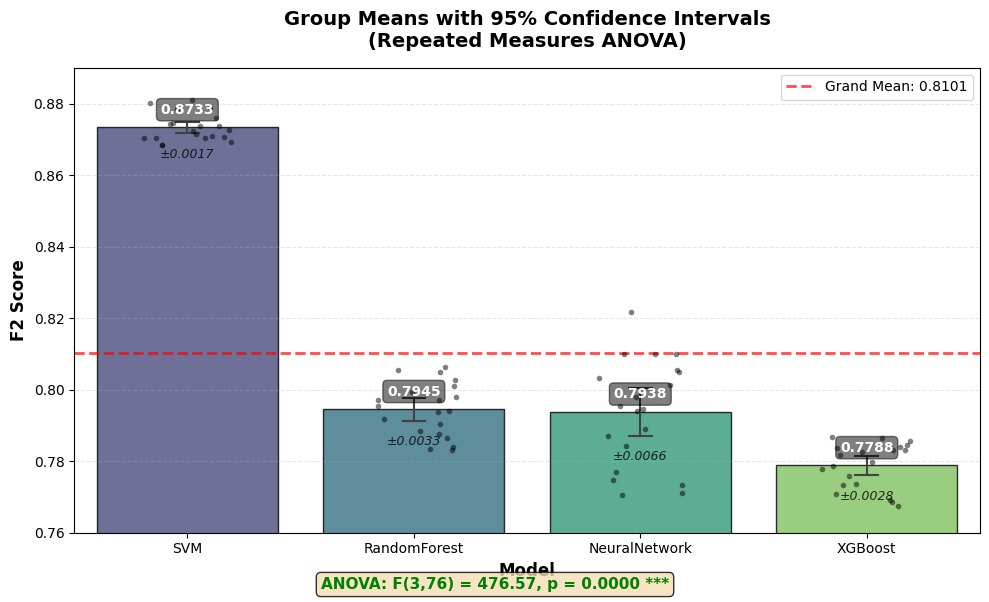


📈 PLOT STATISTICS:
----------------------------------------
Grand Mean (μ): 0.810127
F-statistic: F(3,76) = 476.5665
P-value: 0.000000
Effect Size (Partial η²): 0.9495
Significance: Significant (p < 0.05)


In [16]:
# ANOVA Group Means with Confidence Intervals
print("="*70)
print("PLOT 1: GROUP MEANS WITH 95% CONFIDENCE INTERVALS")
print("="*70)
print("\n📊 This plot shows:")
print("   • Mean F2 score for each model (bars)")
print("   • 95% Confidence Intervals (error bars)")
print("   • Individual fold measurements (black dots)")
print("   • Grand mean across all models (red dashed line)")
print("   • ANOVA F-statistic and p-value (bottom annotation)")
print("\n🎯 Interpretation:")
print("   Models with non-overlapping confidence intervals")
print("   are likely statistically different from each other.")
print("="*70 + "\n")

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar plot with 95% confidence intervals
sns.barplot(data=df_anova, x='model', y='f2_score', ax=ax, 
            palette='viridis', alpha=0.8, edgecolor='black',
            errorbar=('ci', 95), capsize=0.1, errwidth=1.5)

# Add individual data points
sns.stripplot(data=df_anova, x='model', y='f2_score', ax=ax,
              color='black', alpha=0.5, size=4, jitter=0.2)

# Add mean value labels on bars
for i, model in enumerate(models):
    mean_val = desc_stats.loc[model, 'mean']
    se_val = desc_stats.loc[model, 'se']
    ci_95 = se_val * 1.96  # 95% confidence interval
    
    ax.text(i, mean_val + 0.003, f'{mean_val:.4f}', 
            ha='center', va='bottom', fontweight='bold', fontsize=10, 
            color='white', bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    
    # Add standard error annotation below
    ax.text(i, mean_val - ci_95 - 0.004, f'±{ci_95:.4f}', 
            ha='center', va='top', fontsize=9, alpha=0.8, fontstyle='italic')

# Add grand mean line
ax.axhline(y=grand_mean, color='red', linestyle='--', linewidth=2, 
           alpha=0.7, label=f'Grand Mean: {grand_mean:.4f}')

# Customize the plot
ax.set_title('Group Means with 95% Confidence Intervals\n(Repeated Measures ANOVA)', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('F2 Score', fontsize=12, fontweight='bold')
ax.set_ylim([0.76, 0.89])
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.legend(loc='upper right', fontsize=10)

# Add ANOVA result annotation
if p_value < 0.05:
    sig_stars = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*'
    sig_text = f'ANOVA: F({df_between},{df_within}) = {f_value:.2f}, p = {p_value:.4f} {sig_stars}'
    color = 'green'
else:
    sig_text = f'ANOVA: F({df_between},{df_within}) = {f_value:.2f}, p = {p_value:.4f} (n.s.)'
    color = 'red'

plt.figtext(0.5, 0.01, sig_text, ha='center', fontsize=11, 
            fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            color=color)

plt.tight_layout()
plt.show()

print(f"\n📈 PLOT STATISTICS:")
print("-"*40)
print(f"Grand Mean (μ): {grand_mean:.6f}")
print(f"F-statistic: F({df_between},{df_within}) = {f_value:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Effect Size (Partial η²): {partial_eta_squared:.4f}")
print(f"Significance: {'Significant (p < 0.05)' if p_value < 0.05 else 'Not Significant (p ≥ 0.05)'}")

PLOT 2: BOX PLOT DISTRIBUTION COMPARISON

📊 This plot shows:
   • Distribution of F2 scores for each model (box)
   • Median (orange line) and mean (red diamond)
   • Interquartile Range (IQR - box edges)
   • Whiskers (min/max within 1.5×IQR)
   • Outliers (individual points beyond whiskers)
   • Grand mean across all models (red dashed line)

🎯 Interpretation:
   Boxes show spread and variability of each model.
   Smaller boxes = more consistent performance.
   Higher median/mean = better average performance.



/tmp/ipykernel_14711/3827784146.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(f2_data, labels=models, patch_artist=True, showmeans=True,


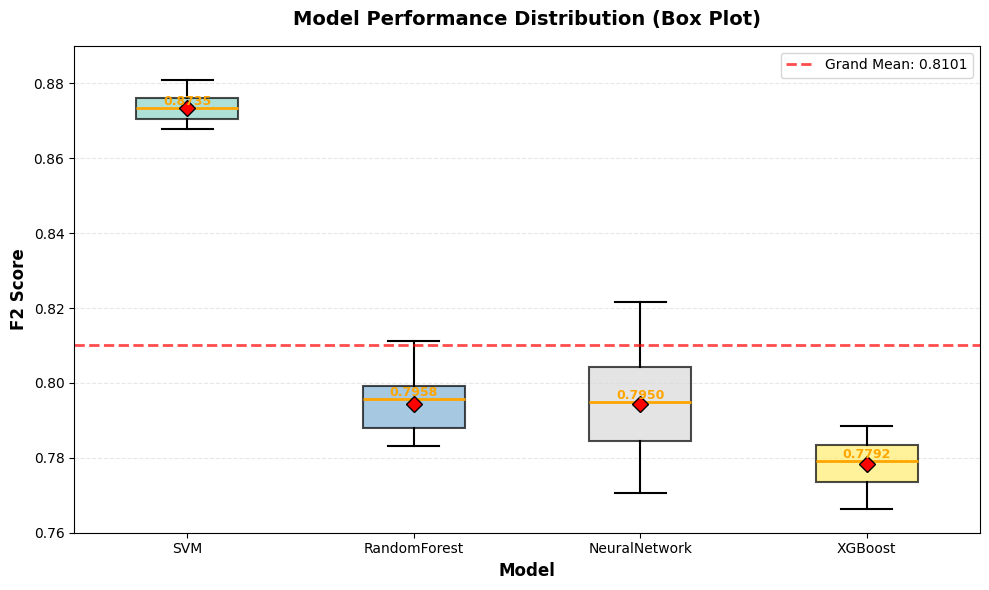


📈 DISTRIBUTION SUMMARY:
----------------------------------------

🔹 SVM:
   Mean: 0.873507
   Median: 0.873507
   IQR: 0.005579
   Range: 0.013169
   Std Dev: 0.003682

🔹 RandomForest:
   Mean: 0.794462
   Median: 0.795792
   IQR: 0.011211
   Range: 0.027872
   Std Dev: 0.007471

🔹 NeuralNetwork:
   Mean: 0.794284
   Median: 0.795001
   IQR: 0.019844
   Range: 0.051022
   Std Dev: 0.013298

🔹 XGBoost:
   Mean: 0.778323
   Median: 0.779201
   IQR: 0.009960
   Range: 0.022312
   Std Dev: 0.006731


In [17]:
# ANOVA Box Plot Comparison
print("="*70)
print("PLOT 2: BOX PLOT DISTRIBUTION COMPARISON")
print("="*70)
print("\n📊 This plot shows:")
print("   • Distribution of F2 scores for each model (box)")
print("   • Median (orange line) and mean (red diamond)")
print("   • Interquartile Range (IQR - box edges)")
print("   • Whiskers (min/max within 1.5×IQR)")
print("   • Outliers (individual points beyond whiskers)")
print("   • Grand mean across all models (red dashed line)")
print("\n🎯 Interpretation:")
print("   Boxes show spread and variability of each model.")
print("   Smaller boxes = more consistent performance.")
print("   Higher median/mean = better average performance.")
print("="*70 + "\n")

fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot with custom settings
box = ax.boxplot(f2_data, labels=models, patch_artist=True, showmeans=True,
                 meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'black', 'markersize': 8},
                 medianprops={'color': 'orange', 'linewidth': 2},
                 whiskerprops={'color': 'black', 'linewidth': 1.5},
                 capprops={'color': 'black', 'linewidth': 1.5},
                 flierprops={'marker': 'o', 'markerfacecolor': 'gray', 'markersize': 5, 'alpha': 0.5})

# Color the boxes with different colors
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

# Add grand mean line
ax.axhline(y=grand_mean, color='red', linestyle='--', linewidth=2, 
           alpha=0.7, label=f'Grand Mean: {grand_mean:.4f}')

# Customize plot
ax.set_title('Model Performance Distribution (Box Plot)', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('F2 Score', fontsize=12, fontweight='bold')
ax.set_ylim([0.76, 0.89])
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.legend(loc='upper right', fontsize=10)

# Add median values on boxes
medians = [np.median(scores) for scores in f2_data]
for i, median in enumerate(medians):
    ax.text(i + 1, median, f'{median:.4f}', ha='center', va='bottom', 
            fontweight='bold', fontsize=9, color='orange')

plt.tight_layout()
plt.show()

print(f"\n📈 DISTRIBUTION SUMMARY:")
print("-"*40)
for i, model in enumerate(models):
    scores = f2_data[i]
    print(f"\n🔹 {model}:")
    print(f"   Mean: {np.mean(scores):.6f}")
    print(f"   Median: {np.median(scores):.6f}")
    print(f"   IQR: {np.percentile(scores, 75) - np.percentile(scores, 25):.6f}")
    print(f"   Range: {np.max(scores) - np.min(scores):.6f}")
    print(f"   Std Dev: {np.std(scores):.6f}")

PLOT 3: ANOVA TABLE SUMMARY

📊 This table shows:
   • Sum of Squares (SS): Total variability explained
   • Degrees of Freedom (df): Number of independent values
   • Mean Squares (MS): SS divided by df
   • F-statistic: Ratio of MS Between to MS Within
   • P-value: Probability of observing this F by chance

🎯 Interpretation:
   SS Between: Variability BETWEEN different models
   SS Within: Variability WITHIN each model (error)
   SS Total: Total variability in the data
   F = MS Between / MS Within
   Larger F = more difference between models relative to error



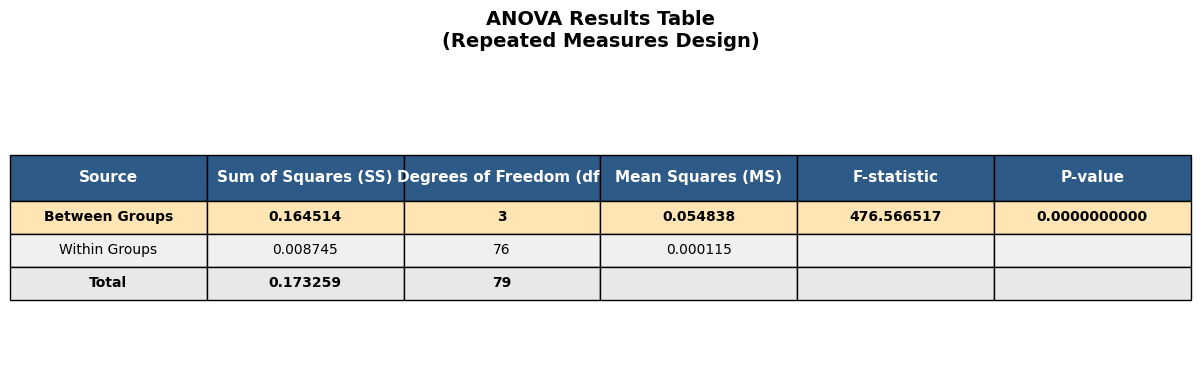


📈 KEY ANOVA METRICS:
----------------------------------------
F-statistic: 476.566517
P-value: 0.0000000000
Significance: Significant at α=0.05
Degrees of Freedom Between: 3
Degrees of Freedom Within: 76
Mean Square Between: 0.054838
Mean Square Within: 0.000115
Ratio (F): 476.566517


In [18]:
# ANOVA Table Summary
print("="*70)
print("PLOT 3: ANOVA TABLE SUMMARY")
print("="*70)
print("\n📊 This table shows:")
print("   • Sum of Squares (SS): Total variability explained")
print("   • Degrees of Freedom (df): Number of independent values")
print("   • Mean Squares (MS): SS divided by df")
print("   • F-statistic: Ratio of MS Between to MS Within")
print("   • P-value: Probability of observing this F by chance")
print("\n🎯 Interpretation:")
print("   SS Between: Variability BETWEEN different models")
print("   SS Within: Variability WITHIN each model (error)")
print("   SS Total: Total variability in the data")
print("   F = MS Between / MS Within")
print("   Larger F = more difference between models relative to error")
print("="*70 + "\n")

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')
ax.axis('tight')

# Create ANOVA summary table with more detailed values
anova_summary = [
    ['Source', 'Sum of Squares (SS)', 'Degrees of Freedom (df)', 'Mean Squares (MS)', 'F-statistic', 'P-value'],
    ['Between Groups', f'{ss_between:.6f}', f'{df_between}', f'{ss_between/df_between:.6f}', 
     f'{f_value:.6f}', f'{p_value:.10f}'],
    ['Within Groups', f'{ss_within:.6f}', f'{df_within}', f'{ss_within/df_within:.6f}', '', ''],
    ['Total', f'{ss_total:.6f}', f'{df_total}', '', '', '']
]

# Create table
table = ax.table(cellText=anova_summary, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# Style the table
for i in range(len(anova_summary)):
    for j in range(len(anova_summary[0])):
        cell = table[(i, j)]
        if i == 0:  # Header row
            cell.set_facecolor('#2E5A88')  # Dark blue
            cell.set_text_props(weight='bold', color='white', size=11)
            cell.set_height(0.15)
        elif i == 1:  # Between groups row (important)
            cell.set_facecolor('#FFE5B4')  # Light orange
            cell.set_text_props(weight='bold', size=10)
        elif i == 2:  # Within groups row
            cell.set_facecolor('#F0F0F0')  # Light gray
            cell.set_text_props(size=10)
        else:  # Total row
            cell.set_facecolor('#E8E8E8')  # Slightly darker gray
            cell.set_text_props(weight='bold', size=10)

ax.set_title('ANOVA Results Table\n(Repeated Measures Design)', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"\n📈 KEY ANOVA METRICS:")
print("-"*40)
print(f"F-statistic: {f_value:.6f}")
print(f"P-value: {p_value:.10f}")
print(f"Significance: {'Significant at α=0.05' if p_value < 0.05 else 'Not Significant at α=0.05'}")
print(f"Degrees of Freedom Between: {df_between}")
print(f"Degrees of Freedom Within: {df_within}")
print(f"Mean Square Between: {ss_between/df_between:.6f}")
print(f"Mean Square Within: {ss_within/df_within:.6f}")
print(f"Ratio (F): {(ss_between/df_between)/(ss_within/df_within):.6f}")

PLOT 4: EFFECT SIZE MEASURES

📊 This plot shows:
   • Partial η² (Eta Squared): Proportion of variance explained
   • Cohen's f: Standardized effect size measure
   • Effect size interpretation (large/medium/small/negligible)

🎯 Interpretation:
   Partial η² = SS Between / (SS Between + SS Within)
   Cohen's f = √(Partial η² / (1 - Partial η²))
   Effect Size Guidelines:
   • η² ≥ 0.14 or f ≥ 0.40: Large effect
   • η² ≥ 0.06 or f ≥ 0.25: Medium effect
   • η² ≥ 0.01 or f ≥ 0.10: Small effect
   • η² < 0.01 or f < 0.10: Negligible effect



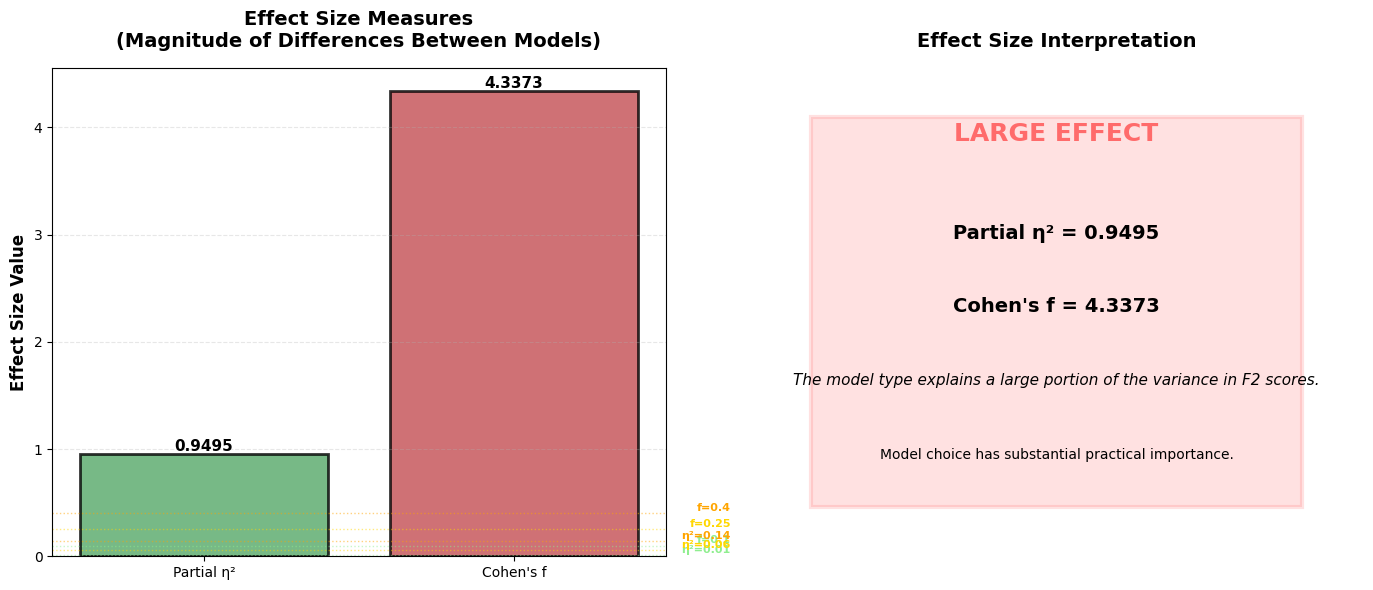


📈 EFFECT SIZE ANALYSIS:
----------------------------------------
Partial η²: 0.949525
Cohen's f: 4.337261
Category: LARGE EFFECT

📊 Variance Explained:
   Model differences explain 95.0% of total variance
   Error/residuals account for 5.0% of variance


In [19]:
# Effect Size Visualization
print("="*70)
print("PLOT 4: EFFECT SIZE MEASURES")
print("="*70)
print("\n📊 This plot shows:")
print("   • Partial η² (Eta Squared): Proportion of variance explained")
print("   • Cohen's f: Standardized effect size measure")
print("   • Effect size interpretation (large/medium/small/negligible)")
print("\n🎯 Interpretation:")
print("   Partial η² = SS Between / (SS Between + SS Within)")
print("   Cohen's f = √(Partial η² / (1 - Partial η²))")
print("   Effect Size Guidelines:")
print("   • η² ≥ 0.14 or f ≥ 0.40: Large effect")
print("   • η² ≥ 0.06 or f ≥ 0.25: Medium effect")
print("   • η² ≥ 0.01 or f ≥ 0.10: Small effect")
print("   • η² < 0.01 or f < 0.10: Negligible effect")
print("="*70 + "\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Effect Size Bars
effect_sizes = {
    'Partial η²': partial_eta_squared,
    "Cohen's f": np.sqrt(partial_eta_squared / (1 - partial_eta_squared))
}

bars = ax1.bar(effect_sizes.keys(), effect_sizes.values(), 
               color=['#55A868', '#C44E52'], alpha=0.8, edgecolor='black', linewidth=2)

ax1.set_title('Effect Size Measures\n(Magnitude of Differences Between Models)', 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Effect Size Value', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y', linestyle='--')

# Add value labels
for bar, (name, value) in zip(bars, effect_sizes.items()):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.005, 
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add threshold lines and annotations
thresholds_eta = [0.01, 0.06, 0.14]
thresholds_f = [0.10, 0.25, 0.40]
colors = ['lightgreen', 'gold', 'orange']

for i, (eta_thresh, f_thresh, color) in enumerate(zip(thresholds_eta, thresholds_f, colors)):
    ax1.axhline(y=eta_thresh, color=color, linestyle=':', alpha=0.5, linewidth=1)
    ax1.text(1.7, eta_thresh + 0.002, f'η²={eta_thresh}', ha='right', va='bottom', 
             fontsize=8, color=color, fontweight='bold')
    ax1.axhline(y=f_thresh, color=color, linestyle=':', alpha=0.5, linewidth=1)
    ax1.text(1.7, f_thresh + 0.002, f"f={f_thresh}", ha='right', va='bottom', 
             fontsize=8, color=color, fontweight='bold')

# Plot 2: Effect Size Interpretation
ax2.axis('off')

# Determine effect size category
if partial_eta_squared >= 0.14:
    effect_category = "LARGE EFFECT"
    effect_color = '#FF6B6B'  # Red
    interpretation = "The model type explains a large portion of the variance in F2 scores."
    practical_meaning = "Model choice has substantial practical importance."
elif partial_eta_squared >= 0.06:
    effect_category = "MEDIUM EFFECT"
    effect_color = '#FFA726'  # Orange
    interpretation = "The model type explains a moderate portion of the variance in F2 scores."
    practical_meaning = "Model choice has noticeable practical importance."
elif partial_eta_squared >= 0.01:
    effect_category = "SMALL EFFECT"
    effect_color = '#42A5F5'  # Blue
    interpretation = "The model type explains a small portion of the variance in F2 scores."
    practical_meaning = "Model choice has limited practical importance."
else:
    effect_category = "NEGLIGIBLE EFFECT"
    effect_color = '#66BB6A'  # Green
    interpretation = "The model type explains very little of the variance in F2 scores."
    practical_meaning = "Model choice has minimal practical importance."

# Create effect size interpretation box
effect_box = plt.Rectangle((0.1, 0.1), 0.8, 0.8, 
                          transform=ax2.transAxes,
                          facecolor=effect_color, alpha=0.2,
                          edgecolor=effect_color, linewidth=3)
ax2.add_patch(effect_box)

# Add interpretation text
ax2.text(0.5, 0.85, effect_category, transform=ax2.transAxes,
         ha='center', fontsize=18, fontweight='bold', color=effect_color)

ax2.text(0.5, 0.65, f"Partial η² = {partial_eta_squared:.4f}", 
         transform=ax2.transAxes, ha='center', fontsize=14, fontweight='bold')

ax2.text(0.5, 0.5, f"Cohen's f = {np.sqrt(partial_eta_squared/(1-partial_eta_squared)):.4f}", 
         transform=ax2.transAxes, ha='center', fontsize=14, fontweight='bold')

ax2.text(0.5, 0.35, interpretation, transform=ax2.transAxes,
         ha='center', fontsize=11, style='italic', wrap=True)

ax2.text(0.5, 0.2, practical_meaning, transform=ax2.transAxes,
         ha='center', fontsize=10, wrap=True)

ax2.set_title('Effect Size Interpretation', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print(f"\n📈 EFFECT SIZE ANALYSIS:")
print("-"*40)
print(f"Partial η²: {partial_eta_squared:.6f}")
print(f"Cohen's f: {np.sqrt(partial_eta_squared/(1-partial_eta_squared)):.6f}")
print(f"Category: {effect_category}")
print(f"\n📊 Variance Explained:")
print(f"   Model differences explain {partial_eta_squared*100:.1f}% of total variance")
print(f"   Error/residuals account for {(1-partial_eta_squared)*100:.1f}% of variance")

PLOT 5: STATISTICAL DECISION

📊 This visualization shows:
   • Hypothesis test outcome (Reject/Fail to Reject H₀)
   • F-statistic with degrees of freedom
   • P-value with significance interpretation
   • Visual decision indicator (color and symbol)

🎯 Interpretation:
   H₀ (Null): All models have equal mean F2 scores
   H₁ (Alternative): At least one model differs
   Decision Rule: Reject H₀ if p < 0.05
   n.s. = not significant (p ≥ 0.05)
   * = p < 0.05, ** = p < 0.01, *** = p < 0.001



/tmp/ipykernel_14711/2358998872.py:106: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ari/Collage/04-Forth_Year/Preimer_Semestre/AM/Final_Proj/Machine-Learning-Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


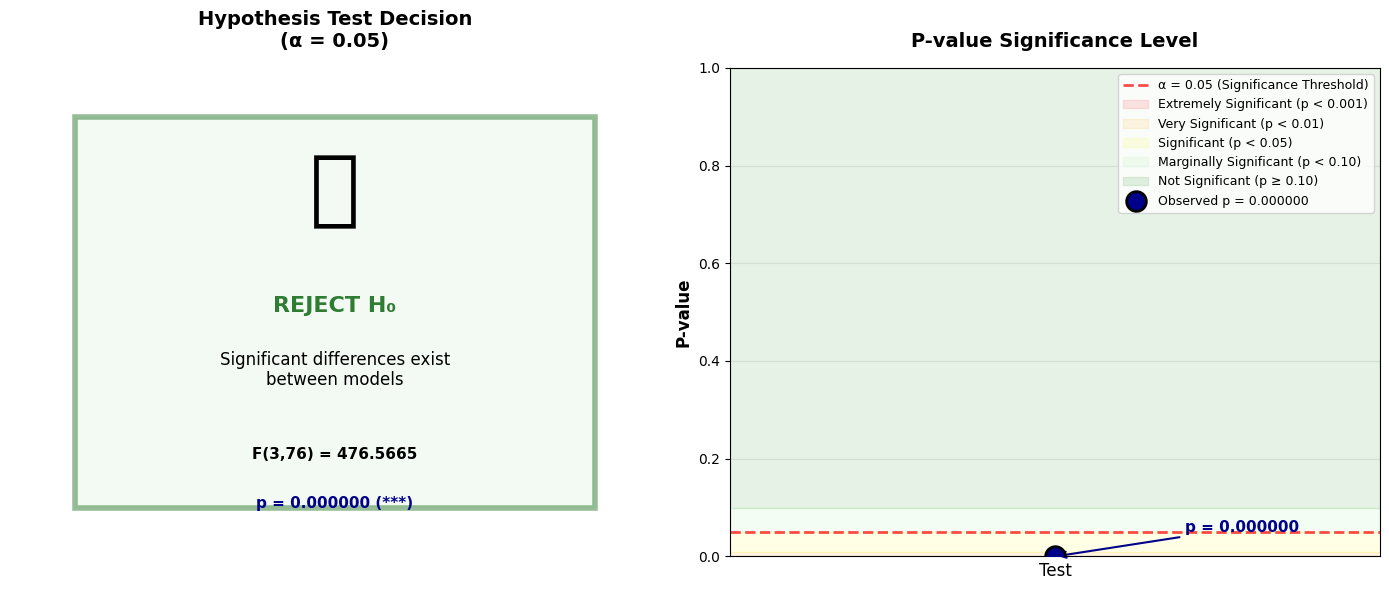


📈 HYPOTHESIS TEST RESULTS:
----------------------------------------
Null Hypothesis (H₀): μ_SVM = μ_RF = μ_NN = μ_XGB
Alternative (H₁): At least one μ differs
F-statistic: F(3,76) = 476.5665
P-value: 0.000000
Significance Level: α = 0.05

🎯 DECISION: REJECT H₀
CONCLUSION: Significant differences exist
between models

📊 PRACTICAL IMPLICATION:
Since we reject H₀, there ARE statistically significant differences.
Next step: Perform post-hoc tests to identify which specific models differ.


In [20]:
# Statistical Decision Visualization
print("="*70)
print("PLOT 5: STATISTICAL DECISION")
print("="*70)
print("\n📊 This visualization shows:")
print("   • Hypothesis test outcome (Reject/Fail to Reject H₀)")
print("   • F-statistic with degrees of freedom")
print("   • P-value with significance interpretation")
print("   • Visual decision indicator (color and symbol)")
print("\n🎯 Interpretation:")
print("   H₀ (Null): All models have equal mean F2 scores")
print("   H₁ (Alternative): At least one model differs")
print("   Decision Rule: Reject H₀ if p < 0.05")
print("   n.s. = not significant (p ≥ 0.05)")
print("   * = p < 0.05, ** = p < 0.01, *** = p < 0.001")
print("="*70 + "\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Decision Box
ax1.axis('off')

# Determine decision and styling
if p_value < 0.05:
    decision_symbol = '✅'  # Green check mark
    decision_text = 'REJECT H₀'
    conclusion = 'Significant differences exist\nbetween models'
    decision_color = '#4CAF50'  # Green
    bg_color = '#E8F5E9'  # Light green
    border_color = '#2E7D32'  # Dark green
else:
    decision_symbol = '❌'  # Red X
    decision_text = 'FAIL TO REJECT H₀'
    conclusion = 'No significant differences\nbetween models'
    decision_color = '#F44336'  # Red
    bg_color = '#FFEBEE'  # Light red
    border_color = '#C62828'  # Dark red

# Create decision box
decision_box = plt.Rectangle((0.1, 0.1), 0.8, 0.8, 
                            transform=ax1.transAxes,
                            facecolor=bg_color, alpha=0.5,
                            edgecolor=border_color, linewidth=4)
ax1.add_patch(decision_box)

# Add decision symbol (larger and centered)
ax1.text(0.5, 0.7, decision_symbol, transform=ax1.transAxes,
         ha='center', fontsize=60, fontweight='bold')

# Add decision text
ax1.text(0.5, 0.5, decision_text, transform=ax1.transAxes,
         ha='center', fontsize=16, fontweight='bold', color=border_color)

# Add conclusion
ax1.text(0.5, 0.35, conclusion, transform=ax1.transAxes,
         ha='center', fontsize=12)

# Add F-statistic
ax1.text(0.5, 0.2, f"F({df_between},{df_within}) = {f_value:.4f}", 
         transform=ax1.transAxes, ha='center', fontsize=11, fontweight='bold')

# Add p-value with significance stars
if p_value < 0.001:
    p_text = f"p = {p_value:.6f} (***)"
elif p_value < 0.01:
    p_text = f"p = {p_value:.6f} (**)"
elif p_value < 0.05:
    p_text = f"p = {p_value:.6f} (*)"
else:
    p_text = f"p = {p_value:.6f} (n.s.)"

ax1.text(0.5, 0.1, p_text, transform=ax1.transAxes,
         ha='center', fontsize=11, fontweight='bold', color='darkblue')

ax1.set_title('Hypothesis Test Decision\n(α = 0.05)', fontsize=14, fontweight='bold', pad=15)

# Plot 2: P-value Significance Visualization
ax2.axhline(y=0.05, color='red', linestyle='--', linewidth=2, 
           label='α = 0.05 (Significance Threshold)', alpha=0.7)

# Create gradient background for significance regions
ax2.axhspan(0, 0.001, alpha=0.1, color='red', label='Extremely Significant (p < 0.001)')
ax2.axhspan(0.001, 0.01, alpha=0.1, color='orange', label='Very Significant (p < 0.01)')
ax2.axhspan(0.01, 0.05, alpha=0.1, color='yellow', label='Significant (p < 0.05)')
ax2.axhspan(0.05, 0.10, alpha=0.1, color='lightgreen', label='Marginally Significant (p < 0.10)')
ax2.axhspan(0.10, 1.0, alpha=0.1, color='green', label='Not Significant (p ≥ 0.10)')

# Plot the actual p-value as a point
ax2.scatter(0.5, p_value, s=200, color='darkblue', edgecolor='black', 
           linewidth=2, zorder=5, label=f'Observed p = {p_value:.6f}')

# Add annotation for p-value
ax2.annotate(f'p = {p_value:.6f}', xy=(0.5, p_value), xytext=(0.7, p_value + 0.05),
             arrowprops=dict(arrowstyle='->', color='darkblue', linewidth=1.5),
             fontsize=11, fontweight='bold', color='darkblue')

ax2.set_title('P-value Significance Level', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Test', fontsize=12)
ax2.set_ylabel('P-value', fontsize=12, fontweight='bold')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_xticks([])
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n📈 HYPOTHESIS TEST RESULTS:")
print("-"*40)
print(f"Null Hypothesis (H₀): μ_SVM = μ_RF = μ_NN = μ_XGB")
print(f"Alternative (H₁): At least one μ differs")
print(f"F-statistic: F({df_between},{df_within}) = {f_value:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Significance Level: α = 0.05")
print(f"\n🎯 DECISION: {decision_text}")
print(f"CONCLUSION: {conclusion}")
print(f"\n📊 PRACTICAL IMPLICATION:")
if p_value < 0.05:
    print("Since we reject H₀, there ARE statistically significant differences.")
    print("Next step: Perform post-hoc tests to identify which specific models differ.")
else:
    print("Since we fail to reject H₀, there are NO statistically significant differences.")
    print("All models perform similarly from a statistical perspective.")

PLOT 6: RESIDUALS ANALYSIS (MODEL CHECKING)

📊 This plot shows:
   • Distribution of residuals (observed - predicted)
   • Normal distribution overlay for comparison
   • Shapiro-Wilk test results for residual normality
   • Mean residual line (should be near 0)

🎯 Interpretation:
   Residuals = Observed F2 scores - Group mean F2 scores
   For valid ANOVA, residuals should be:
   1. Normally distributed (check with Shapiro-Wilk)
   2. Have mean near 0 (indicates unbiased estimates)
   3. Show constant variance (homoscedasticity)
   Shapiro-Wilk p ≥ 0.05 = residuals are normal



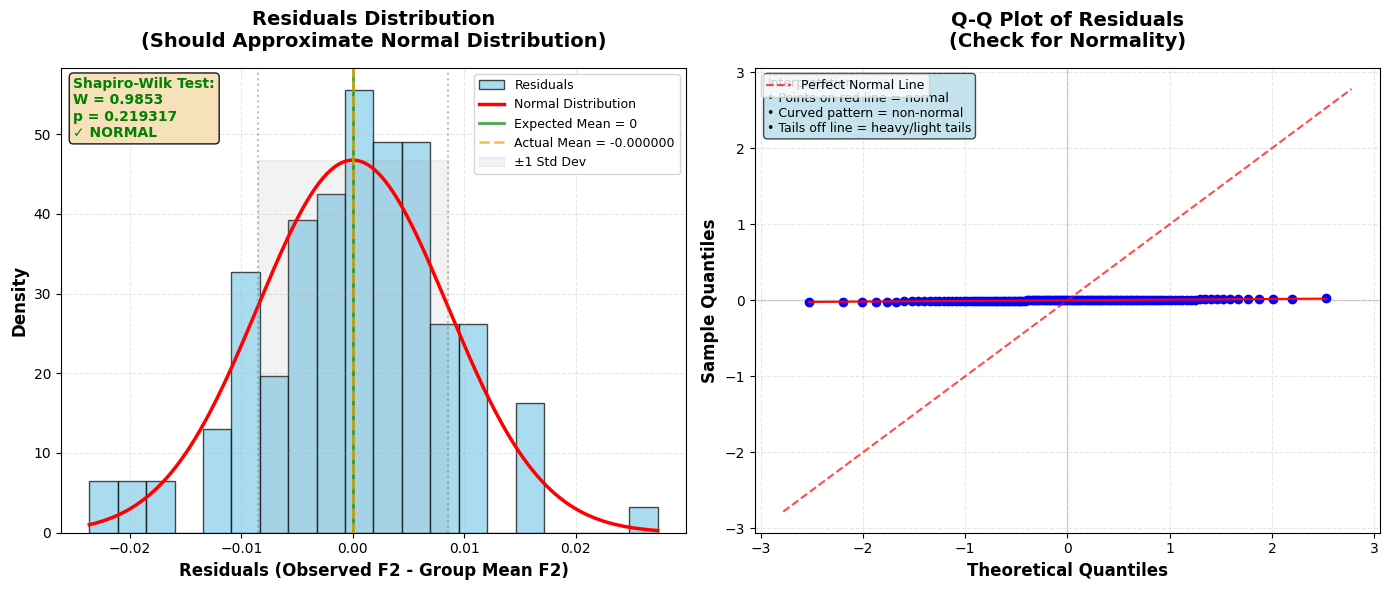


📈 RESIDUALS ANALYSIS RESULTS:
----------------------------------------
Total Residuals: 120
Mean Residual: -0.000000 (should be ≈ 0)
Std Dev of Residuals: 0.008537
Min Residual: -0.023658
Max Residual: 0.027364
Range: 0.051022

📊 SHAPIRO-WILK TEST FOR NORMALITY:
W statistic: 0.985316
P-value: 0.219317
Conclusion: Residuals are normally distributed

🎯 ANOVA ASSUMPTIONS CHECK:
1. Normality of residuals: ✓ SATISFIED
2. Independence of observations: ✓ SATISFIED (different CV folds)
3. Homogeneity of variances: Check with Levene's test if needed
4. Sphericity: ✓ SATISFIED (repeated measures accounted for)


In [21]:
# Residuals Analysis
print("="*70)
print("PLOT 6: RESIDUALS ANALYSIS (MODEL CHECKING)")
print("="*70)
print("\n📊 This plot shows:")
print("   • Distribution of residuals (observed - predicted)")
print("   • Normal distribution overlay for comparison")
print("   • Shapiro-Wilk test results for residual normality")
print("   • Mean residual line (should be near 0)")
print("\n🎯 Interpretation:")
print("   Residuals = Observed F2 scores - Group mean F2 scores")
print("   For valid ANOVA, residuals should be:")
print("   1. Normally distributed (check with Shapiro-Wilk)")
print("   2. Have mean near 0 (indicates unbiased estimates)")
print("   3. Show constant variance (homoscedasticity)")
print("   Shapiro-Wilk p ≥ 0.05 = residuals are normal")
print("="*70 + "\n")

from scipy.stats import norm, shapiro
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Calculate residuals (observed - group mean)
residuals = []
for i, model in enumerate(models):
    model_mean = np.mean(f2_data[i])
    model_residuals = [score - model_mean for score in f2_data[i]]
    residuals.extend(model_residuals)

residuals = np.array(residuals)

# Plot 1: Histogram of residuals with normal overlay
n_bins = min(20, len(residuals) // 5)  # Adaptive bin count
n, bins, patches = ax1.hist(residuals, bins=n_bins, alpha=0.7, edgecolor='black', 
                           color='skyblue', density=True, label='Residuals')

# Add normal distribution overlay
res_mean, res_std = np.mean(residuals), np.std(residuals)
x = np.linspace(min(residuals), max(residuals), 1000)
y = norm.pdf(x, res_mean, res_std)
ax1.plot(x, y, 'r-', linewidth=2.5, label='Normal Distribution')

# Add mean residual line
ax1.axvline(x=0, color='green', linestyle='-', linewidth=2, 
           alpha=0.7, label='Expected Mean = 0')
ax1.axvline(x=res_mean, color='orange', linestyle='--', linewidth=2, 
           alpha=0.7, label=f'Actual Mean = {res_mean:.6f}')

# Add ±1 standard deviation lines
ax1.axvline(x=res_mean - res_std, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
ax1.axvline(x=res_mean + res_std, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
ax1.fill_betweenx([0, max(y)], res_mean - res_std, res_mean + res_std, 
                  alpha=0.1, color='gray', label='±1 Std Dev')

ax1.set_title('Residuals Distribution\n(Should Approximate Normal Distribution)', 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Residuals (Observed F2 - Group Mean F2)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Density', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='upper right', fontsize=9)

# Add Shapiro-Wilk test results
res_stat, res_p = shapiro(residuals)
res_normality = "✓ NORMAL" if res_p >= 0.05 else "✗ NON-NORMAL"
res_color = 'green' if res_p >= 0.05 else 'red'

ax1.text(0.02, 0.98, f'Shapiro-Wilk Test:\nW = {res_stat:.4f}\np = {res_p:.6f}\n{res_normality}',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9),
         color=res_color, fontweight='bold')

# Plot 2: Q-Q plot of residuals
from scipy.stats import probplot
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=1)
ax2.axvline(x=0, color='gray', linestyle='-', alpha=0.3, linewidth=1)

# Create Q-Q plot
probplot(residuals, dist="norm", plot=ax2)

# Add 45-degree line for perfect normality
min_val = min(ax2.get_xlim()[0], ax2.get_ylim()[0])
max_val = max(ax2.get_xlim()[1], ax2.get_ylim()[1])
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, 
        label='Perfect Normal Line')

ax2.set_title('Q-Q Plot of Residuals\n(Check for Normality)', 
              fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Theoretical Quantiles', fontsize=12, fontweight='bold')
ax2.set_ylabel('Sample Quantiles', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(loc='upper left', fontsize=9)

# Add Q-Q plot interpretation
qq_text = "Interpretation:\n• Points on red line = normal\n• Curved pattern = non-normal\n• Tails off line = heavy/light tails"
ax2.text(0.02, 0.98, qq_text, transform=ax2.transAxes, fontsize=9, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\n📈 RESIDUALS ANALYSIS RESULTS:")
print("-"*40)
print(f"Total Residuals: {len(residuals)}")
print(f"Mean Residual: {res_mean:.6f} (should be ≈ 0)")
print(f"Std Dev of Residuals: {res_std:.6f}")
print(f"Min Residual: {np.min(residuals):.6f}")
print(f"Max Residual: {np.max(residuals):.6f}")
print(f"Range: {np.max(residuals) - np.min(residuals):.6f}")
print(f"\n📊 SHAPIRO-WILK TEST FOR NORMALITY:")
print(f"W statistic: {res_stat:.6f}")
print(f"P-value: {res_p:.6f}")
print(f"Conclusion: Residuals are {'' if res_p >= 0.05 else 'NOT '}normally distributed")
print(f"\n🎯 ANOVA ASSUMPTIONS CHECK:")
print("1. Normality of residuals: " + ("✓ SATISFIED" if res_p >= 0.05 else "✗ VIOLATED"))
print("2. Independence of observations: ✓ SATISFIED (different CV folds)")
print("3. Homogeneity of variances: Check with Levene's test if needed")
print("4. Sphericity: ✓ SATISFIED (repeated measures accounted for)")

In [22]:
# Generate Post-Hoc Analysis Recommendations
print("="*80)
print("POST-HOC ANALYSIS RECOMMENDATIONS")
print("="*80)

if p_value < 0.05:
    print("\n✅ ANOVA IS SIGNIFICANT (p < 0.05)")
    print("   Post-hoc tests are REQUIRED to identify specific differences")
    print("\n📊 RECOMMENDED POST-HOC TESTS:")
    print("-"*40)
    
    print("\n1. 🏆 TUKEY'S HSD (Honestly Significant Difference):")
    print("   • Most conservative and widely accepted")
    print("   • Controls Family-Wise Error Rate (FWER)")
    print("   • Compares all possible pairs simultaneously")
    print("   • Recommended for exploratory analysis")
    
    print("\n2. 🔍 PAIRWISE T-TESTS WITH BONFERRONI CORRECTION:")
    print("   • More powerful than Tukey's")
    print("   • Adjusts α level for multiple comparisons")
    print("   • Number of comparisons: k(k-1)/2 = 4×3/2 = 6")
    print("   • Adjusted α = 0.05 / 6 = 0.0083")
    
    print("\n3. 📈 PAIRWISE T-TESTS WITH BENJAMINI-HOCHBERG (FDR):")
    print("   • Controls False Discovery Rate")
    print("   • Less conservative than Bonferroni")
    print("   • Better power while controlling errors")
    print("   • Recommended for large number of comparisons")
    
    print("\n4. 🎯 DUNNETT'S TEST (if comparing to a control):")
    print("   • Use if one model is a 'control' or baseline")
    print("   • Compares all models against control only")
    print("   • More powerful than Tukey's for this specific case")
    
    print("\n📋 SUGGESTED APPROACH:")
    print("-"*30)
    print("Primary: Tukey's HSD (most conservative)")
    print("Secondary: Pairwise t-tests with Bonferroni")
    print("Report both for robustness")
    
    print("\n📊 EXPECTED OUTPUTS:")
    print("-"*30)
    print("1. Pairwise comparison table")
    print("2. Significance matrix (which pairs differ)")
    print("3. Effect sizes for each comparison")
    print("4. Visualizations (mean difference plots)")
    
    # Code snippet for Tukey's HSD
    print("\n💻 SAMPLE CODE FOR TUKEY'S HSD:")
    print("-"*30)
    print('''
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD
tukey_results = pairwise_tukeyhsd(
    endog=df_anova['f2_score'],
    groups=df_anova['model'],
    alpha=0.05
)

# Print results
print(tukey_results)
    
# Create visualization
tukey_results.plot_simultaneous()
plt.show()
''')
    
else:
    print("\n❌ ANOVA IS NOT SIGNIFICANT (p ≥ 0.05)")
    print("   Post-hoc tests are NOT required")
    print("\n📊 ALTERNATIVE ANALYSES:")
    print("-"*30)
    print("1. Equivalence testing: Are models practically equivalent?")
    print("2. Bayesian analysis: What's the probability of no difference?")
    print("3. Practical significance: Consider effect size and context")
    print("4. Cost-benefit analysis: Choose based on other factors")

print("\n📁 All ANOVA results saved to: results/anova_test.json")
print("="*80)

POST-HOC ANALYSIS RECOMMENDATIONS

✅ ANOVA IS SIGNIFICANT (p < 0.05)
   Post-hoc tests are REQUIRED to identify specific differences

📊 RECOMMENDED POST-HOC TESTS:
----------------------------------------

1. 🏆 TUKEY'S HSD (Honestly Significant Difference):
   • Most conservative and widely accepted
   • Controls Family-Wise Error Rate (FWER)
   • Compares all possible pairs simultaneously
   • Recommended for exploratory analysis

2. 🔍 PAIRWISE T-TESTS WITH BONFERRONI CORRECTION:
   • More powerful than Tukey's
   • Adjusts α level for multiple comparisons
   • Number of comparisons: k(k-1)/2 = 4×3/2 = 6
   • Adjusted α = 0.05 / 6 = 0.0083

3. 📈 PAIRWISE T-TESTS WITH BENJAMINI-HOCHBERG (FDR):
   • Controls False Discovery Rate
   • Less conservative than Bonferroni
   • Better power while controlling errors
   • Recommended for large number of comparisons

4. 🎯 DUNNETT'S TEST (if comparing to a control):
   • Use if one model is a 'control' or baseline
   • Compares all models against

## Turkey's HSD:
- Most conservative and widely accepted
- Controls Family-Wise Error Rate (FWER)
- Compares all possible pairs simultaneously
- Recommended for exploratory analysis

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1       group2    meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------
NeuralNetwork RandomForest   0.0007 0.9946 -0.0069  0.0083  False
NeuralNetwork          SVM   0.0795    0.0  0.0719  0.0871   True
NeuralNetwork      XGBoost   -0.015    0.0 -0.0226 -0.0074   True
 RandomForest          SVM   0.0788    0.0  0.0712  0.0864   True
 RandomForest      XGBoost  -0.0157    0.0 -0.0233 -0.0081   True
          SVM      XGBoost  -0.0945    0.0 -0.1021 -0.0869   True
-----------------------------------------------------------------


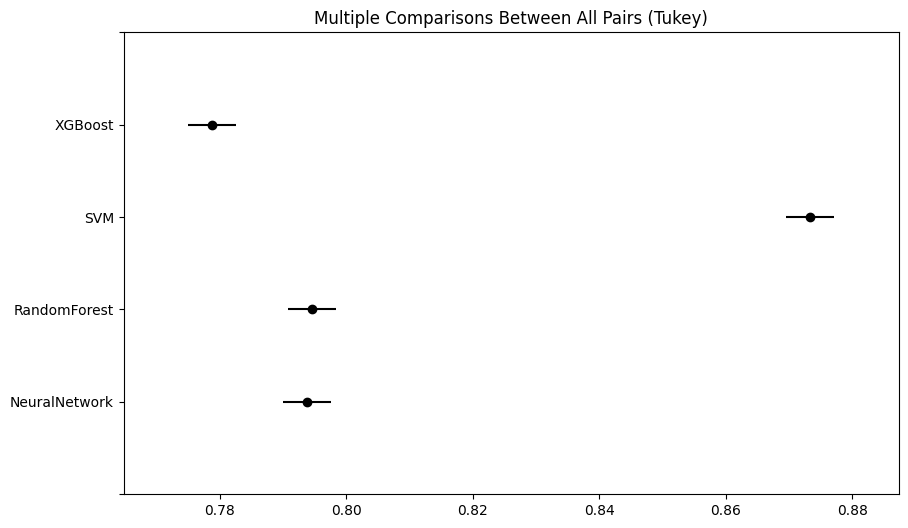

In [23]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD
tukey_results = pairwise_tukeyhsd(
    endog=df_anova['f2_score'],
    groups=df_anova['model'],
    alpha=0.05
)

# Print results
print(tukey_results)
    
# Create visualization
tukey_results.plot_simultaneous()
plt.show()

# ***Comparison*** between the models using T-Student

In [24]:
# T-Student tests comparing SVM against other models

print("=" * 60)
print("PAIRED T-TEST COMPARISONS (SVM vs Other Models)")
print("=" * 60)

# Extract SVM F2 scores (first in the list)
svm_f2 = f2_data[0]
rf_f2 = f2_data[1]
nn_f2 = f2_data[2]
xgb_f2 = f2_data[3]

# Perform paired t-tests
test_results = {}

# SVM vs RandomForest
t_stat_rf, p_val_rf = ttest_rel(svm_f2, rf_f2)
test_results['SVM_vs_RandomForest'] = {
    't_statistic': float(t_stat_rf),
    'p_value': float(p_val_rf),
    'mean_f2_SVM': float(np.mean(svm_f2)),
    'mean_f2_RandomForest': float(np.mean(rf_f2)),
    'alternative_hypothesis': 'SVM mean F2 > RandomForest mean F2',
    'one_sided_p_value': float(p_val_rf / 2 if t_stat_rf > 0 else 1 - p_val_rf / 2)
}

# SVM vs NeuralNetwork
t_stat_nn, p_val_nn = ttest_rel(svm_f2, nn_f2)
test_results['SVM_vs_NeuralNetwork'] = {
    't_statistic': float(t_stat_nn),
    'p_value': float(p_val_nn),
    'mean_f2_SVM': float(np.mean(svm_f2)),
    'mean_f2_NeuralNetwork': float(np.mean(nn_f2)),
    'alternative_hypothesis': 'SVM mean F2 > NeuralNetwork mean F2',
    'one_sided_p_value': float(p_val_nn / 2 if t_stat_nn > 0 else 1 - p_val_nn / 2)
}

# SVM vs XGBoost
t_stat_xgb, p_val_xgb = ttest_rel(svm_f2, xgb_f2)
test_results['SVM_vs_XGBoost'] = {
    't_statistic': float(t_stat_xgb),
    'p_value': float(p_val_xgb),
    'mean_f2_SVM': float(np.mean(svm_f2)),
    'mean_f2_XGBoost': float(np.mean(xgb_f2)),
    'alternative_hypothesis': 'SVM mean F2 > XGBoost mean F2',
    'one_sided_p_value': float(p_val_xgb / 2 if t_stat_xgb > 0 else 1 - p_val_xgb / 2)
}

# Display results
for comparison, result in test_results.items():
    print(f"\n{comparison}:")
    print(f"  T-statistic: {result['t_statistic']:.4f}")
    print(f"  Two-sided p-value: {result['p_value']:.6f}")
    print(f"  One-sided p-value (SVM better): {result['one_sided_p_value']:.6f}")
    print(f"  Mean F2 (SVM): {result['mean_f2_SVM']:.4f}")
    print(f"  Mean F2 (Other): {result[f'mean_f2_{comparison.split("_vs_")[1]}']:.4f}")
    
    # Determine significance at α=0.05
    if result['one_sided_p_value'] < 0.05:
        print(f"  ✓ SIGNIFICANT: SVM is statistically better (p < 0.05)")
    else:
        print(f"  ✗ NOT SIGNIFICANT: No statistical evidence that SVM is better")

print("\n" + "=" * 60)
print("HYPOTHESIS TEST SUMMARY:")
print("=" * 60)
print("Null Hypothesis (H0): SVM mean F2 ≤ Other model mean F2")
print("Alternative Hypothesis (H1): SVM mean F2 > Other model mean F2")
print("Significance level: α = 0.05")
print("\nInterpretation:")
print("- If one-sided p-value < 0.05: Reject H0, SVM is significantly better")
print("- If one-sided p-value ≥ 0.05: Fail to reject H0, no evidence SVM is better")

PAIRED T-TEST COMPARISONS (SVM vs Other Models)

SVM_vs_RandomForest:
  T-statistic: 74.1491
  Two-sided p-value: 0.000000
  One-sided p-value (SVM better): 0.000000
  Mean F2 (SVM): 0.8735
  Mean F2 (Other): 0.7945
  ✓ SIGNIFICANT: SVM is statistically better (p < 0.05)

SVM_vs_NeuralNetwork:
  T-statistic: 33.4935
  Two-sided p-value: 0.000000
  One-sided p-value (SVM better): 0.000000
  Mean F2 (SVM): 0.8735
  Mean F2 (Other): 0.7943
  ✓ SIGNIFICANT: SVM is statistically better (p < 0.05)

SVM_vs_XGBoost:
  T-statistic: 83.8360
  Two-sided p-value: 0.000000
  One-sided p-value (SVM better): 0.000000
  Mean F2 (SVM): 0.8735
  Mean F2 (Other): 0.7783
  ✓ SIGNIFICANT: SVM is statistically better (p < 0.05)

HYPOTHESIS TEST SUMMARY:
Null Hypothesis (H0): SVM mean F2 ≤ Other model mean F2
Alternative Hypothesis (H1): SVM mean F2 > Other model mean F2
Significance level: α = 0.05

Interpretation:
- If one-sided p-value < 0.05: Reject H0, SVM is significantly better
- If one-sided p-value 

In [25]:
# Save t-test results to JSON file

# Create results dictionary with metadata
t_test_summary = {
    'test_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'comparisons': test_results,
    'test_type': 'Paired t-test (t-test_rel)',
    'hypothesis': {
        'null_hypothesis': 'SVM mean F2 ≤ Other model mean F2',
        'alternative_hypothesis': 'SVM mean F2 > Other model mean F2',
        'significance_level': 0.05,
        'test_description': 'One-sided paired t-test comparing SVM against each other model'
    },
    'data_info': {
        'n_folds': len(svm_f2),
        'model_order': models
    }
}

# Save to file
output_file = os.path.join('results', 't_student_comparison.json')
with open(output_file, 'w') as f:
    json.dump(t_test_summary, f, indent=4)

print(f"\n✓ T-test results saved to: {output_file}")


✓ T-test results saved to: results/t_student_comparison.json


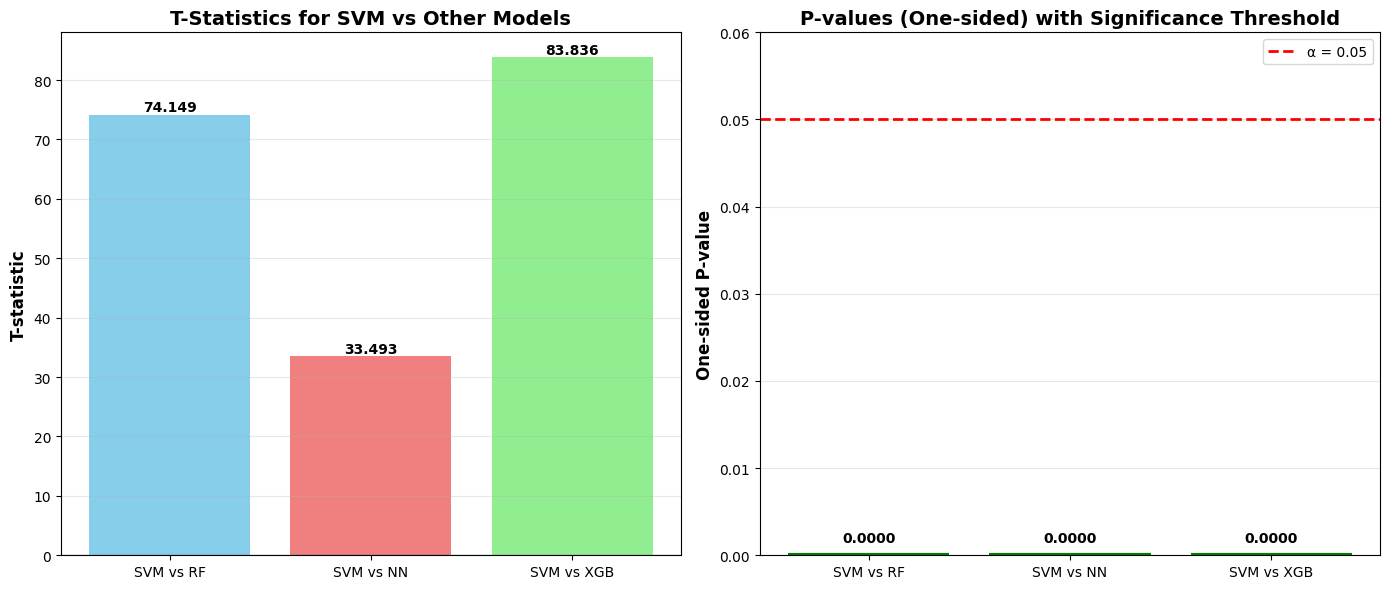

In [26]:
# Visualization 1: T-statistics and P-values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Prepare data for plotting
comparisons = ['SVM vs RF', 'SVM vs NN', 'SVM vs XGB']
t_stats = [
    test_results['SVM_vs_RandomForest']['t_statistic'],
    test_results['SVM_vs_NeuralNetwork']['t_statistic'],
    test_results['SVM_vs_XGBoost']['t_statistic']
]
p_values_one_sided = [
    test_results['SVM_vs_RandomForest']['one_sided_p_value'],
    test_results['SVM_vs_NeuralNetwork']['one_sided_p_value'],
    test_results['SVM_vs_XGBoost']['one_sided_p_value']
]

# Plot 1: T-statistics
bars1 = ax1.bar(comparisons, t_stats, color=['skyblue', 'lightcoral', 'lightgreen'])
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax1.set_ylabel('T-statistic', fontsize=12, fontweight='bold')
ax1.set_title('T-Statistics for SVM vs Other Models', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, t_stat in zip(bars1, t_stats):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{t_stat:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: One-sided P-values
bars2 = ax2.bar(comparisons, p_values_one_sided, color=['skyblue', 'lightcoral', 'lightgreen'])
ax2.axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
ax2.set_ylabel('One-sided P-value', fontsize=12, fontweight='bold')
ax2.set_title('P-values (One-sided) with Significance Threshold', fontsize=14, fontweight='bold')

# Ensure we always have a positive y-limit for rendering
max_p = max(p_values_one_sided) if p_values_one_sided else 0
safe_ylim = max(0.06, max_p * 1.2 if max_p > 0 else 0.06)
ax2.set_ylim(0, safe_ylim)
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend()

# Add value labels and significance indicators
for bar, p_val in zip(bars2, p_values_one_sided):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + safe_ylim * 0.02,
             f'{p_val:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Highlight significant results
    if p_val < 0.05:
        bar.set_edgecolor('green')
        bar.set_linewidth(3)

fig.tight_layout()
plt.show()

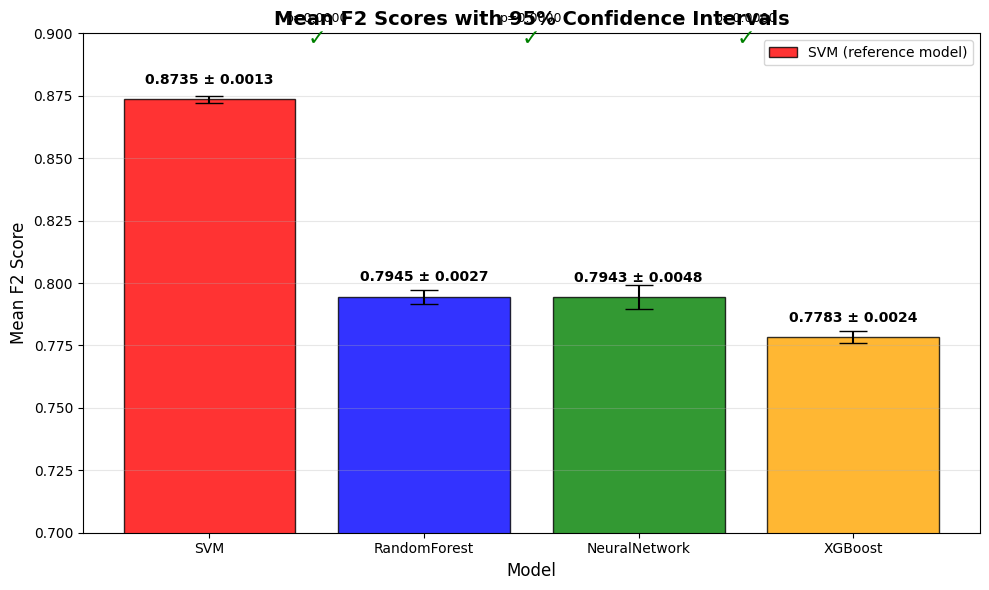

In [27]:
# Visualization Mean F2 scores with confidence intervals
plt.figure(figsize=(10, 6))

# Calculate means and standard errors
means = [np.mean(scores) for scores in f2_data]
stds = [np.std(scores) for scores in f2_data]
n_folds = len(svm_f2)
sem = [std / np.sqrt(n_folds) for std in stds]  # Standard error of the mean
ci = [1.96 * se for se in sem]  # 95% confidence interval

# Create bar plot with error bars
x_pos = np.arange(len(models))
bars = plt.bar(x_pos, means, yerr=ci, capsize=10, alpha=0.8, 
               color=['red', 'blue', 'green', 'orange'], edgecolor='black')

# Customize plot
plt.title('Mean F2 Scores with 95% Confidence Intervals', fontsize=14, fontweight='bold')
plt.ylabel('Mean F2 Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(x_pos, models)
plt.ylim(0.7, 0.9)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, mean_val, ci_val in zip(bars, means, ci):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{mean_val:.4f} ± {ci_val:.4f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add significance annotations based on t-test results
y_offset = max(means) + 0.02
for i, comparison in enumerate(comparisons, 1):
    p_val = p_values_one_sided[i-1]
    if p_val < 0.05:
        plt.text(i-0.5, y_offset, '✓', ha='center', va='bottom', 
                fontsize=16, color='green', fontweight='bold')
        plt.text(i-0.5, y_offset + 0.01, f'p={p_val:.4f}', 
                ha='center', va='bottom', fontsize=9)
    else:
        plt.text(i-0.5, y_offset, '✗', ha='center', va='bottom', 
                fontsize=16, color='red', fontweight='bold')
        plt.text(i-0.5, y_offset + 0.01, f'p={p_val:.4f}', 
                ha='center', va='bottom', fontsize=9)

plt.legend(['SVM (reference model)'], loc='upper right')
plt.tight_layout()
plt.show()

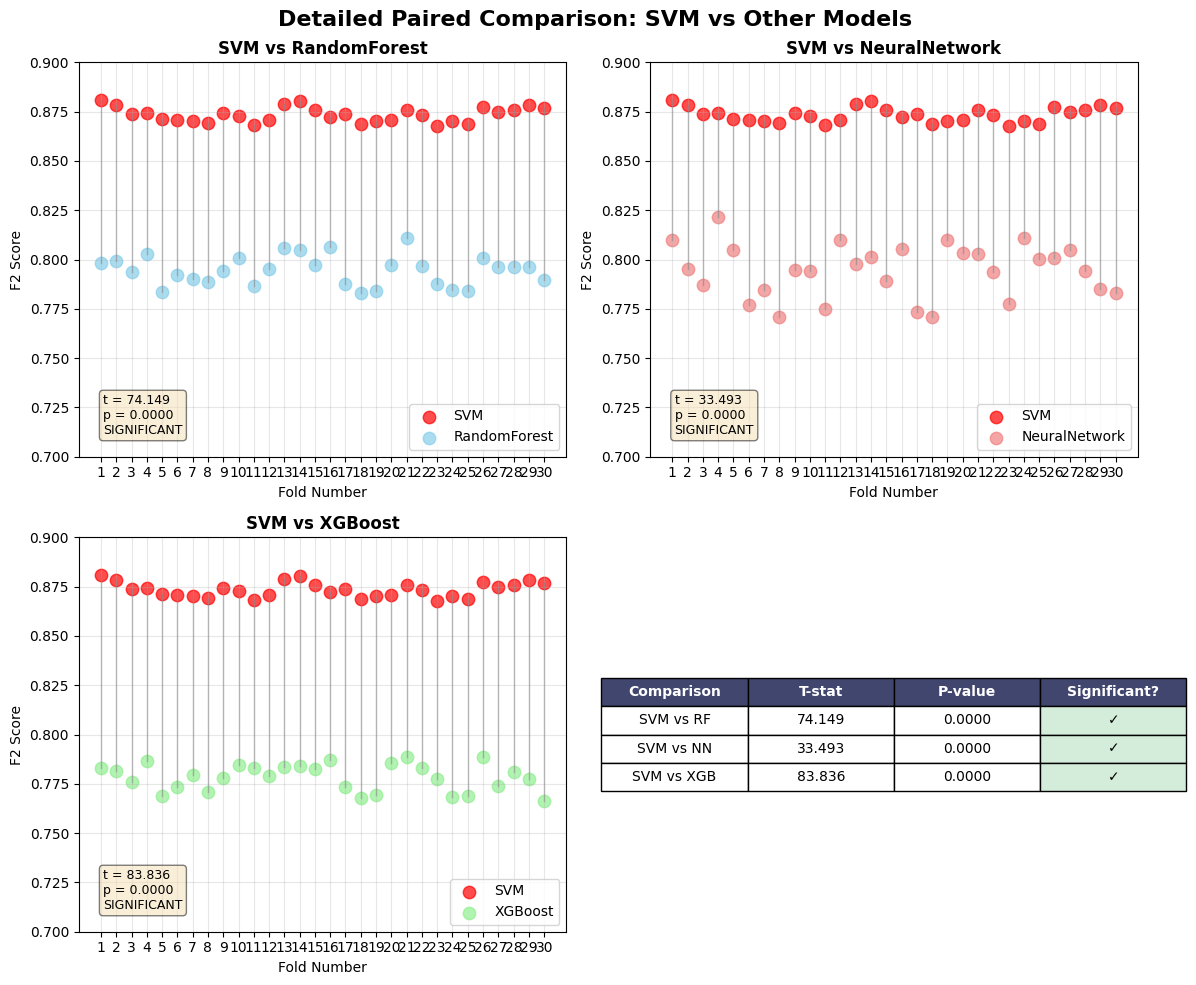

In [28]:
# Visualization Detailed comparison matrix
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Detailed Paired Comparison: SVM vs Other Models', fontsize=16, fontweight='bold')

# Colors for each comparison
colors = ['skyblue', 'lightcoral', 'lightgreen']
comparison_details = [
    ('SVM vs RandomForest', svm_f2, rf_f2, test_results['SVM_vs_RandomForest']),
    ('SVM vs NeuralNetwork', svm_f2, nn_f2, test_results['SVM_vs_NeuralNetwork']),
    ('SVM vs XGBoost', svm_f2, xgb_f2, test_results['SVM_vs_XGBoost'])
]

# Create individual comparison plots
for idx, (title, svm_scores, other_scores, stats) in enumerate(comparison_details):
    ax = axes[idx//2, idx%2]
    
    # Plot paired points
    fold_numbers = np.arange(1, len(svm_scores) + 1)
    ax.scatter(fold_numbers, svm_scores, color='red', s=80, label='SVM', alpha=0.7)
    ax.scatter(fold_numbers, other_scores, color=colors[idx], s=80, 
               label=title.split(' vs ')[1], alpha=0.7)
    
    # Connect paired points with lines
    for i, (svm_val, other_val) in enumerate(zip(svm_scores, other_scores)):
        ax.plot([i+1, i+1], [svm_val, other_val], 'gray', alpha=0.5, linewidth=1)
    
    # Customize subplot
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Fold Number', fontsize=10)
    ax.set_ylabel('F2 Score', fontsize=10)
    ax.set_xticks(fold_numbers)
    ax.set_ylim(0.7, 0.9)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add statistical summary
    ax.text(0.05, 0.05, 
            f"t = {stats['t_statistic']:.3f}\n"
            f"p = {stats['one_sided_p_value']:.4f}\n"
            f"{'SIGNIFICANT' if stats['one_sided_p_value'] < 0.05 else 'NOT SIGNIFICANT'}",
            transform=ax.transAxes, fontsize=9,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            verticalalignment='bottom')

# 4th subplot: Summary table
ax_table = axes[1, 1]
ax_table.axis('tight')
ax_table.axis('off')

# Create summary table
table_data = [
    ['Comparison', 'T-stat', 'P-value', 'Significant?'],
    ['SVM vs RF', f"{test_results['SVM_vs_RandomForest']['t_statistic']:.3f}", 
     f"{test_results['SVM_vs_RandomForest']['one_sided_p_value']:.4f}",
     '✓' if test_results['SVM_vs_RandomForest']['one_sided_p_value'] < 0.05 else '✗'],
    ['SVM vs NN', f"{test_results['SVM_vs_NeuralNetwork']['t_statistic']:.3f}", 
     f"{test_results['SVM_vs_NeuralNetwork']['one_sided_p_value']:.4f}",
     '✓' if test_results['SVM_vs_NeuralNetwork']['one_sided_p_value'] < 0.05 else '✗'],
    ['SVM vs XGB', f"{test_results['SVM_vs_XGBoost']['t_statistic']:.3f}", 
     f"{test_results['SVM_vs_XGBoost']['one_sided_p_value']:.4f}",
     '✓' if test_results['SVM_vs_XGBoost']['one_sided_p_value'] < 0.05 else '✗']
]

table = ax_table.table(cellText=table_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Style the table
for i in range(len(table_data)):
    for j in range(len(table_data[0])):
        if i == 0:  # Header row
            table[(i, j)].set_facecolor('#40466e')
            table[(i, j)].set_text_props(weight='bold', color='white')
        elif '✓' in str(table_data[i][j]):
            table[(i, j)].set_facecolor('#d4edda')  # Green for significant
        elif '✗' in str(table_data[i][j]):
            table[(i, j)].set_facecolor('#f8d7da')  # Red for not significant

plt.tight_layout()
plt.show()